In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2
Enter your authorization code:
··········
Mounted at /content/gdrive


In [62]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
#from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
df=pd.read_csv('fer2013.csv')

print(df.info())
print(df["Usage"].value_counts())

print(df.head())
X_train,train_y,X_test,test_y=[],[],[],[]

for index, row in df.iterrows():
    val=row['pixels'].split(" ")
    try:
        if 'Training' in row['Usage']:
           X_train.append(np.array(val,'float32'))
           train_y.append(row['emotion'])
        elif 'PublicTest' in row['Usage']:
           X_test.append(np.array(val,'float32'))
           test_y.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None
Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [55]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 200
width, height = 48, 48

In [9]:
X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

train_y=to_categorical(train_y, num_classes=num_labels)
test_y=to_categorical(test_y, num_classes=num_labels)

#cannot produce
#normalizing data between oand 1
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [10]:
print(f"shape:{X_train.shape}")

shape:(28709, 48, 48, 1)


In [43]:
##designing the cnn
#1st convolution layer
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:]), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

# 2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

# 3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

# Fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation='softmax'))

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 conv2d_14 (Conv2D)          (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 conv2d_16 (Conv2D)          (None, 18, 18, 64)        36928     
                                                      

In [45]:
def plot_losses(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, 'b-', label='Training loss')  # 'b-' for blue solid line
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')  # 'r-' for red solid line
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [49]:
class PlotLossesCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            try:
                plot_losses(self.model.history)
            except KeyError:
                print("Loss information not found in the history. Skipping plot.")

In [50]:
#Compliling the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

Epoch 1/200
449/449 [==============================] - 5s 12ms/step - loss: 1.4978 - accuracy: 0.4378 - val_loss: 1.5165 - val_accuracy: 0.4269
Epoch 2/200
449/449 [==============================] - 5s 12ms/step - loss: 1.4950 - accuracy: 0.4397 - val_loss: 1.5116 - val_accuracy: 0.4171
Epoch 3/200
449/449 [==============================] - 6s 12ms/step - loss: 1.4896 - accuracy: 0.4401 - val_loss: 1.5052 - val_accuracy: 0.4308
Epoch 4/200
449/449 [==============================] - 6s 12ms/step - loss: 1.4885 - accuracy: 0.4390 - val_loss: 1.5096 - val_accuracy: 0.4277
Epoch 5/200
449/449 [==============================] - 5s 12ms/step - loss: 1.4834 - accuracy: 0.4439 - val_loss: 1.5122 - val_accuracy: 0.4241
Epoch 6/200
448/449 [============================>.] - ETA: 0s - loss: 1.4770 - accuracy: 0.4465

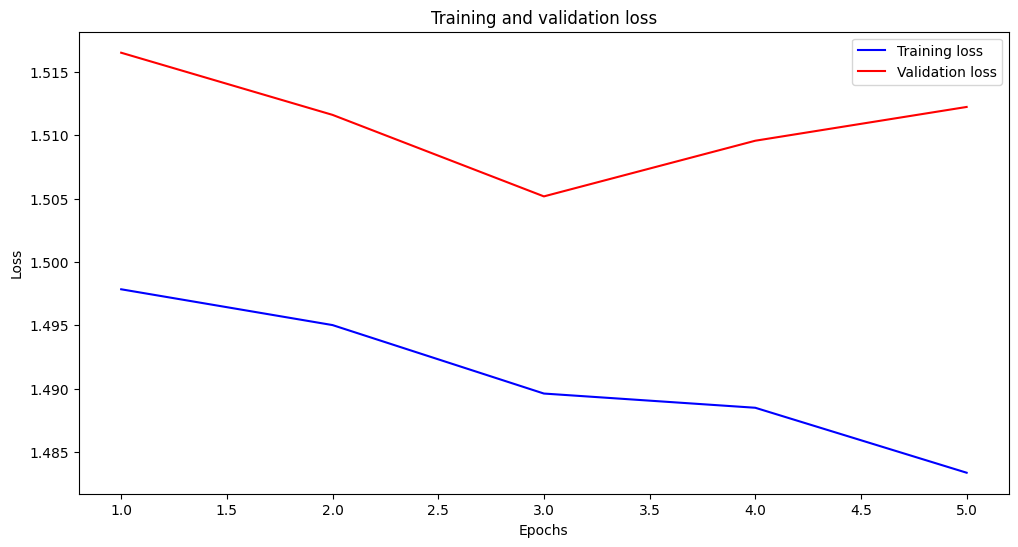

449/449 [==============================] - 6s 12ms/step - loss: 1.4768 - accuracy: 0.4466 - val_loss: 1.5053 - val_accuracy: 0.4235
Epoch 7/200
449/449 [==============================] - 6s 12ms/step - loss: 1.4782 - accuracy: 0.4440 - val_loss: 1.5088 - val_accuracy: 0.4277
Epoch 8/200
449/449 [==============================] - 7s 15ms/step - loss: 1.4745 - accuracy: 0.4508 - val_loss: 1.5116 - val_accuracy: 0.4249
Epoch 9/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4668 - accuracy: 0.4565 - val_loss: 1.5078 - val_accuracy: 0.4305
Epoch 10/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4690 - accuracy: 0.4512 - val_loss: 1.5040 - val_accuracy: 0.4216
Epoch 11/200
448/449 [============================>.] - ETA: 0s - loss: 1.4597 - accuracy: 0.4542

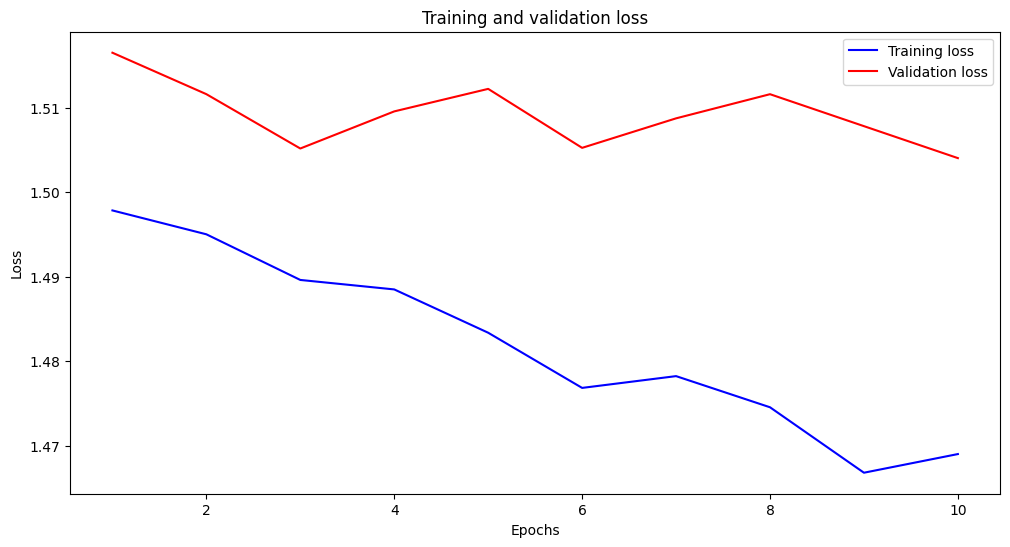

449/449 [==============================] - 10s 23ms/step - loss: 1.4601 - accuracy: 0.4541 - val_loss: 1.5214 - val_accuracy: 0.4246
Epoch 12/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4590 - accuracy: 0.4559 - val_loss: 1.4991 - val_accuracy: 0.4296
Epoch 13/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4620 - accuracy: 0.4550 - val_loss: 1.5197 - val_accuracy: 0.4241
Epoch 14/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4557 - accuracy: 0.4563 - val_loss: 1.5091 - val_accuracy: 0.4246
Epoch 15/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4489 - accuracy: 0.4614 - val_loss: 1.5229 - val_accuracy: 0.4230
Epoch 16/200
448/449 [============================>.] - ETA: 0s - loss: 1.4444 - accuracy: 0.4615

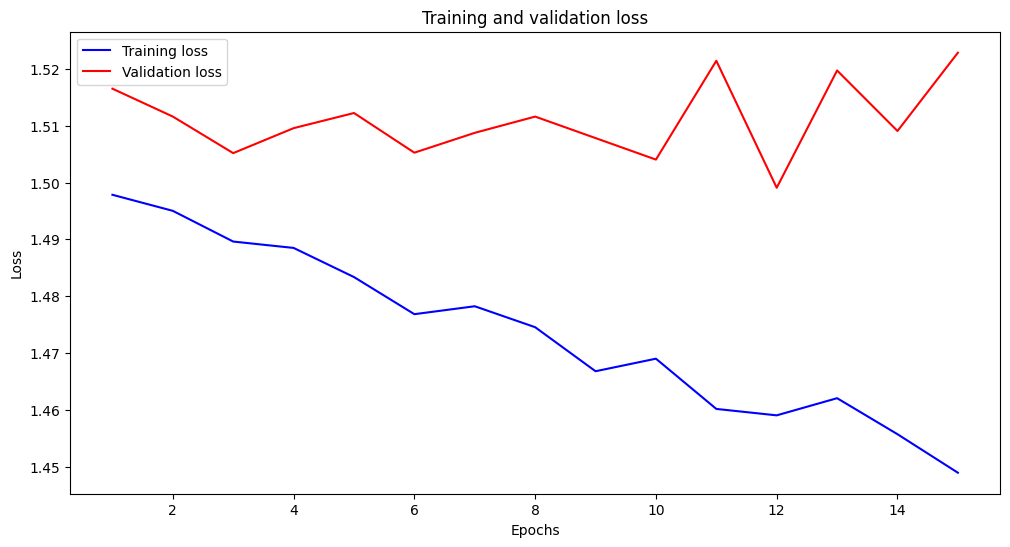

449/449 [==============================] - 11s 24ms/step - loss: 1.4444 - accuracy: 0.4614 - val_loss: 1.5213 - val_accuracy: 0.4196
Epoch 17/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4448 - accuracy: 0.4651 - val_loss: 1.5104 - val_accuracy: 0.4327
Epoch 18/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4459 - accuracy: 0.4626 - val_loss: 1.5230 - val_accuracy: 0.4196
Epoch 19/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4433 - accuracy: 0.4656 - val_loss: 1.5080 - val_accuracy: 0.4361
Epoch 20/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4359 - accuracy: 0.4708 - val_loss: 1.5217 - val_accuracy: 0.4352
Epoch 21/200
449/449 [==============================] - ETA: 0s - loss: 1.4308 - accuracy: 0.4704

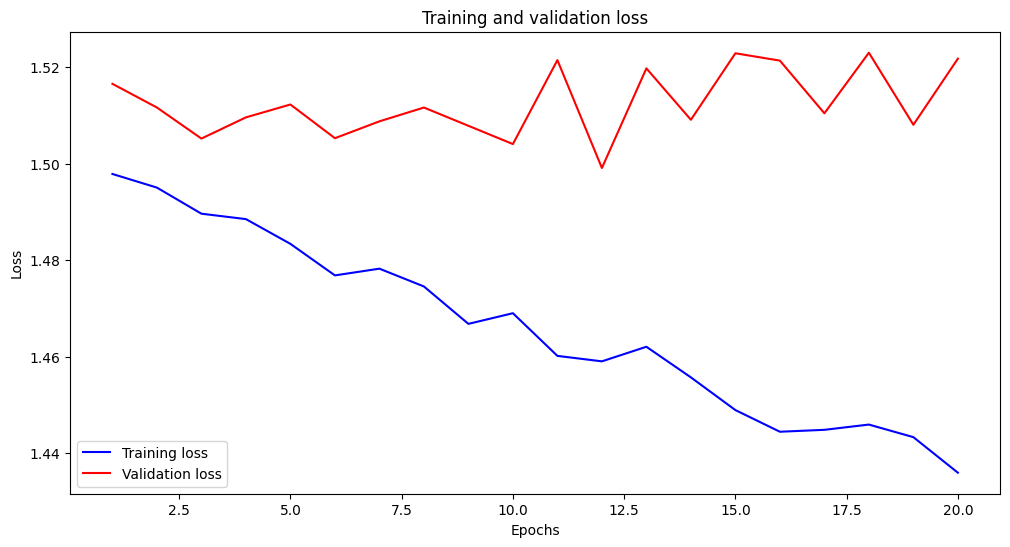

449/449 [==============================] - 10s 23ms/step - loss: 1.4308 - accuracy: 0.4704 - val_loss: 1.5192 - val_accuracy: 0.4361
Epoch 22/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4255 - accuracy: 0.4724 - val_loss: 1.5366 - val_accuracy: 0.4285
Epoch 23/200
449/449 [==============================] - 10s 23ms/step - loss: 1.4229 - accuracy: 0.4766 - val_loss: 1.5079 - val_accuracy: 0.4302
Epoch 24/200
449/449 [==============================] - 10s 23ms/step - loss: 1.4156 - accuracy: 0.4761 - val_loss: 1.5144 - val_accuracy: 0.4235
Epoch 25/200
449/449 [==============================] - 10s 23ms/step - loss: 1.4199 - accuracy: 0.4749 - val_loss: 1.4985 - val_accuracy: 0.4327
Epoch 26/200
448/449 [============================>.] - ETA: 0s - loss: 1.4157 - accuracy: 0.4754

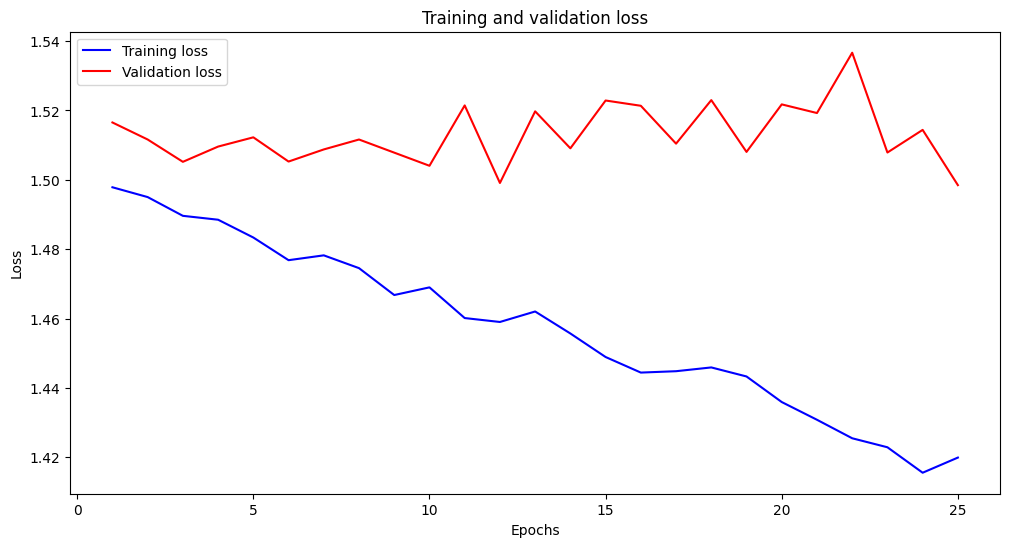

449/449 [==============================] - 11s 24ms/step - loss: 1.4158 - accuracy: 0.4754 - val_loss: 1.5134 - val_accuracy: 0.4274
Epoch 27/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4072 - accuracy: 0.4801 - val_loss: 1.5348 - val_accuracy: 0.4224
Epoch 28/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4092 - accuracy: 0.4783 - val_loss: 1.5135 - val_accuracy: 0.4274
Epoch 29/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4001 - accuracy: 0.4854 - val_loss: 1.5020 - val_accuracy: 0.4285
Epoch 30/200
449/449 [==============================] - 10s 22ms/step - loss: 1.4000 - accuracy: 0.4816 - val_loss: 1.5187 - val_accuracy: 0.4324
Epoch 31/200
447/449 [============================>.] - ETA: 0s - loss: 1.3924 - accuracy: 0.4872

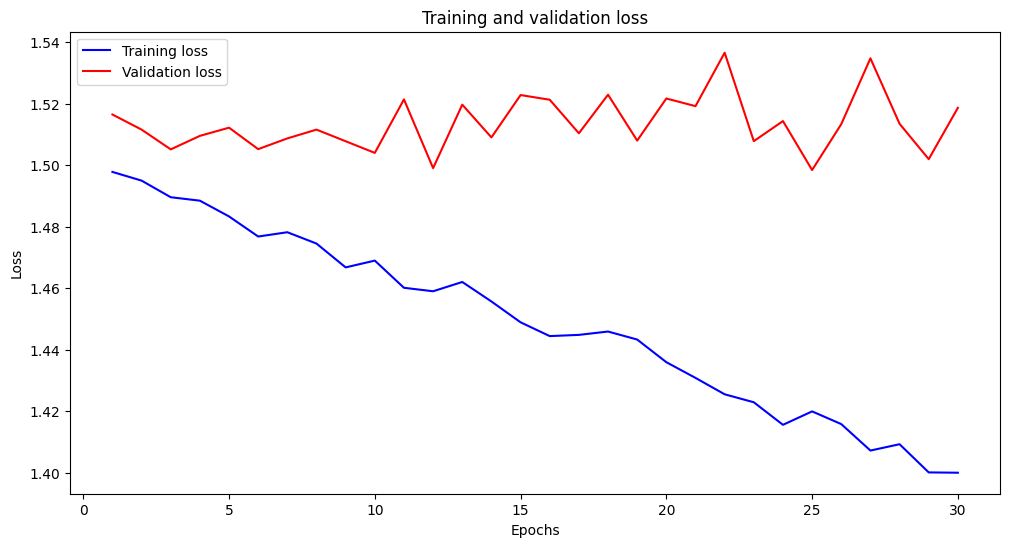

449/449 [==============================] - 10s 23ms/step - loss: 1.3921 - accuracy: 0.4873 - val_loss: 1.5028 - val_accuracy: 0.4330
Epoch 32/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3949 - accuracy: 0.4888 - val_loss: 1.5085 - val_accuracy: 0.4372
Epoch 33/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3956 - accuracy: 0.4910 - val_loss: 1.5222 - val_accuracy: 0.4355
Epoch 34/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3960 - accuracy: 0.4873 - val_loss: 1.5195 - val_accuracy: 0.4310
Epoch 35/200
449/449 [==============================] - 10s 21ms/step - loss: 1.3839 - accuracy: 0.4921 - val_loss: 1.5258 - val_accuracy: 0.4246
Epoch 36/200
448/449 [============================>.] - ETA: 0s - loss: 1.3918 - accuracy: 0.4870

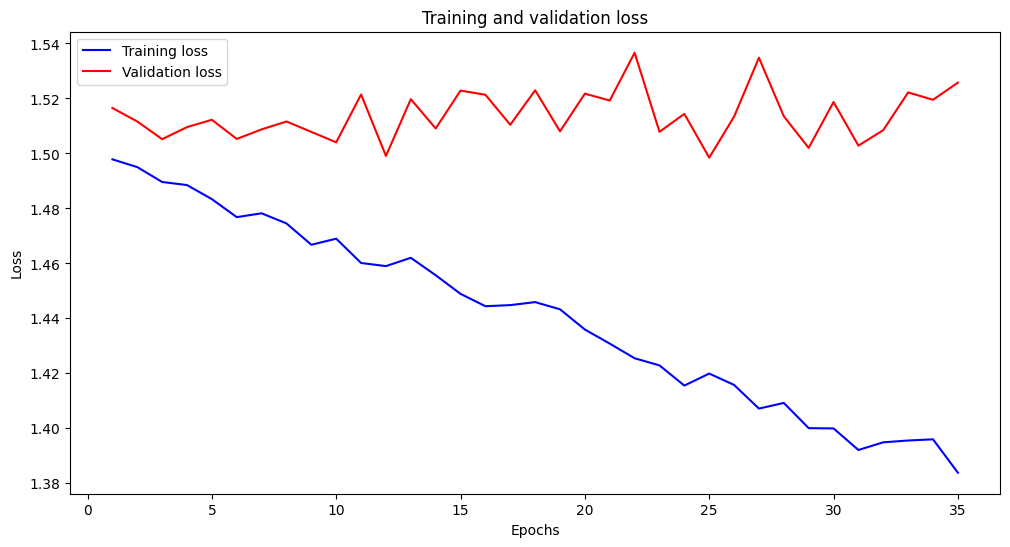

449/449 [==============================] - 10s 23ms/step - loss: 1.3915 - accuracy: 0.4871 - val_loss: 1.5065 - val_accuracy: 0.4355
Epoch 37/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3840 - accuracy: 0.4941 - val_loss: 1.5113 - val_accuracy: 0.4413
Epoch 38/200
449/449 [==============================] - 10s 23ms/step - loss: 1.3766 - accuracy: 0.4979 - val_loss: 1.5257 - val_accuracy: 0.4285
Epoch 39/200
449/449 [==============================] - 11s 24ms/step - loss: 1.3735 - accuracy: 0.4968 - val_loss: 1.5193 - val_accuracy: 0.4280
Epoch 40/200
449/449 [==============================] - 10s 23ms/step - loss: 1.3744 - accuracy: 0.4963 - val_loss: 1.5382 - val_accuracy: 0.4230
Epoch 41/200
448/449 [============================>.] - ETA: 0s - loss: 1.3715 - accuracy: 0.4981

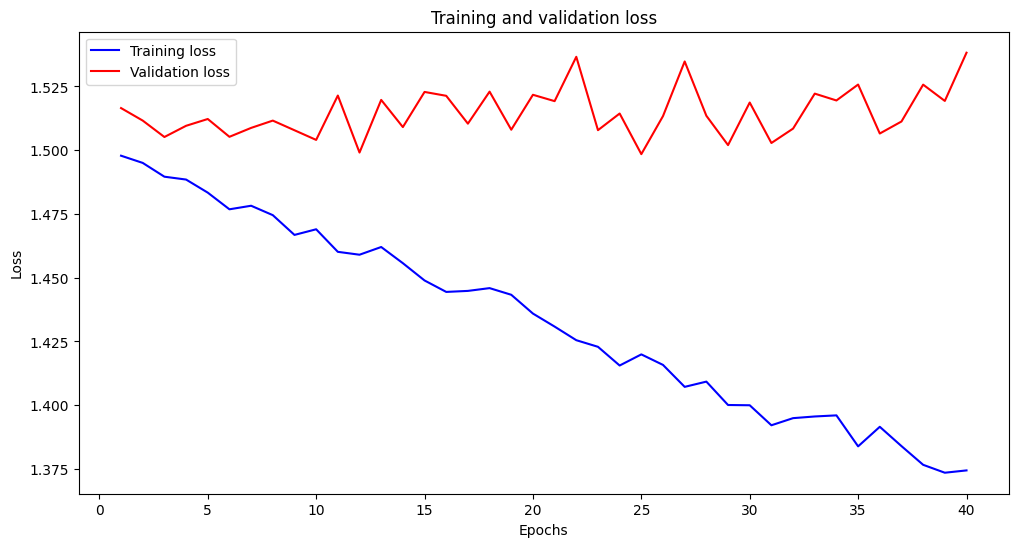

449/449 [==============================] - 11s 25ms/step - loss: 1.3717 - accuracy: 0.4980 - val_loss: 1.5094 - val_accuracy: 0.4335
Epoch 42/200
449/449 [==============================] - 10s 23ms/step - loss: 1.3636 - accuracy: 0.5023 - val_loss: 1.5182 - val_accuracy: 0.4310
Epoch 43/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3635 - accuracy: 0.4991 - val_loss: 1.5056 - val_accuracy: 0.4372
Epoch 44/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3596 - accuracy: 0.5007 - val_loss: 1.5250 - val_accuracy: 0.4308
Epoch 45/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3631 - accuracy: 0.5029 - val_loss: 1.5142 - val_accuracy: 0.4436
Epoch 46/200
447/449 [============================>.] - ETA: 0s - loss: 1.3512 - accuracy: 0.5065

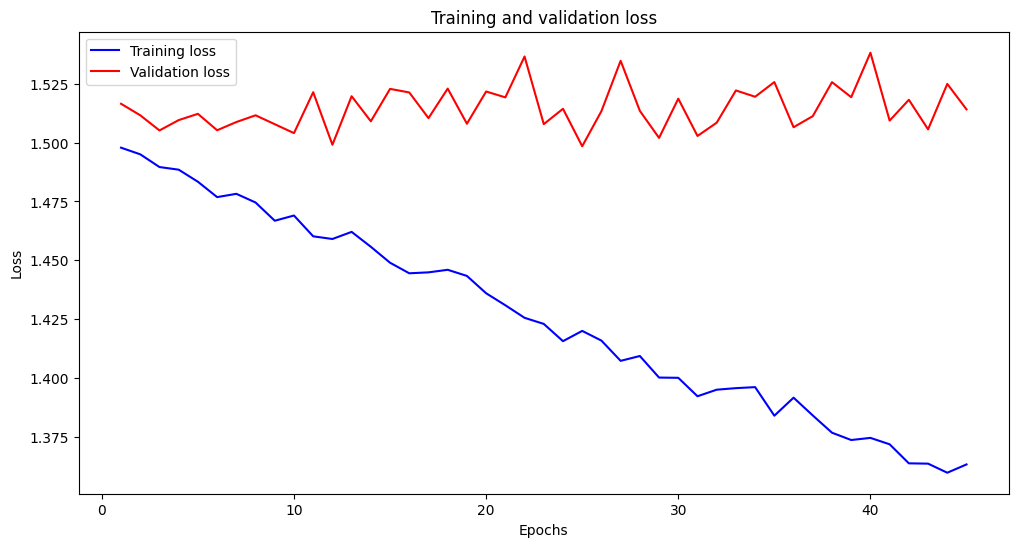

449/449 [==============================] - 11s 24ms/step - loss: 1.3516 - accuracy: 0.5061 - val_loss: 1.5286 - val_accuracy: 0.4283
Epoch 47/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3522 - accuracy: 0.5061 - val_loss: 1.5181 - val_accuracy: 0.4335
Epoch 48/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3536 - accuracy: 0.5038 - val_loss: 1.5310 - val_accuracy: 0.4341
Epoch 49/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3469 - accuracy: 0.5067 - val_loss: 1.5075 - val_accuracy: 0.4288
Epoch 50/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3485 - accuracy: 0.5092 - val_loss: 1.5464 - val_accuracy: 0.4205
Epoch 51/200
448/449 [============================>.] - ETA: 0s - loss: 1.3517 - accuracy: 0.5083

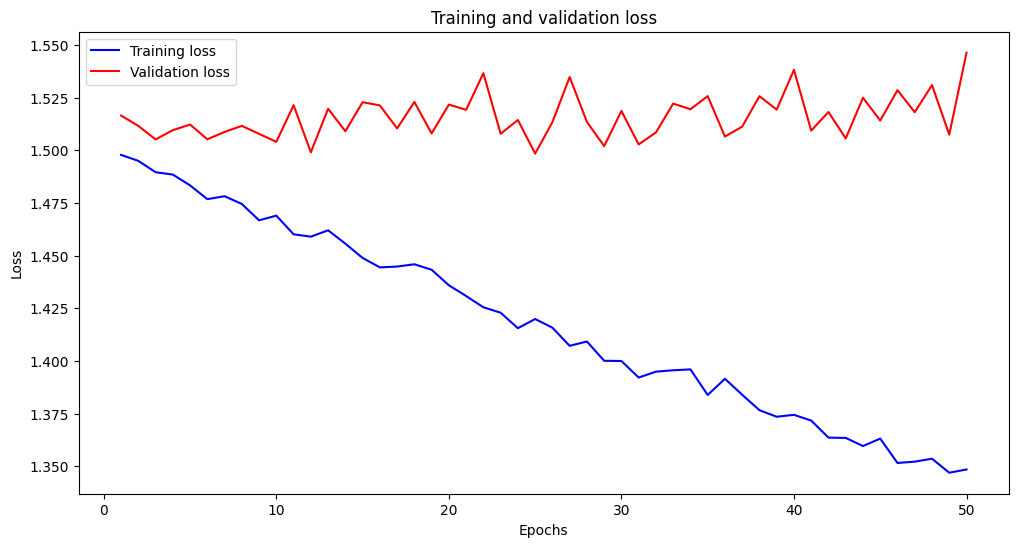

449/449 [==============================] - 10s 23ms/step - loss: 1.3516 - accuracy: 0.5083 - val_loss: 1.5242 - val_accuracy: 0.4308
Epoch 52/200
449/449 [==============================] - 10s 21ms/step - loss: 1.3303 - accuracy: 0.5181 - val_loss: 1.5156 - val_accuracy: 0.4310
Epoch 53/200
449/449 [==============================] - 9s 21ms/step - loss: 1.3398 - accuracy: 0.5154 - val_loss: 1.5337 - val_accuracy: 0.4257
Epoch 54/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3321 - accuracy: 0.5138 - val_loss: 1.5230 - val_accuracy: 0.4522
Epoch 55/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3316 - accuracy: 0.5189 - val_loss: 1.5040 - val_accuracy: 0.4497
Epoch 56/200
448/449 [============================>.] - ETA: 0s - loss: 1.3293 - accuracy: 0.5180

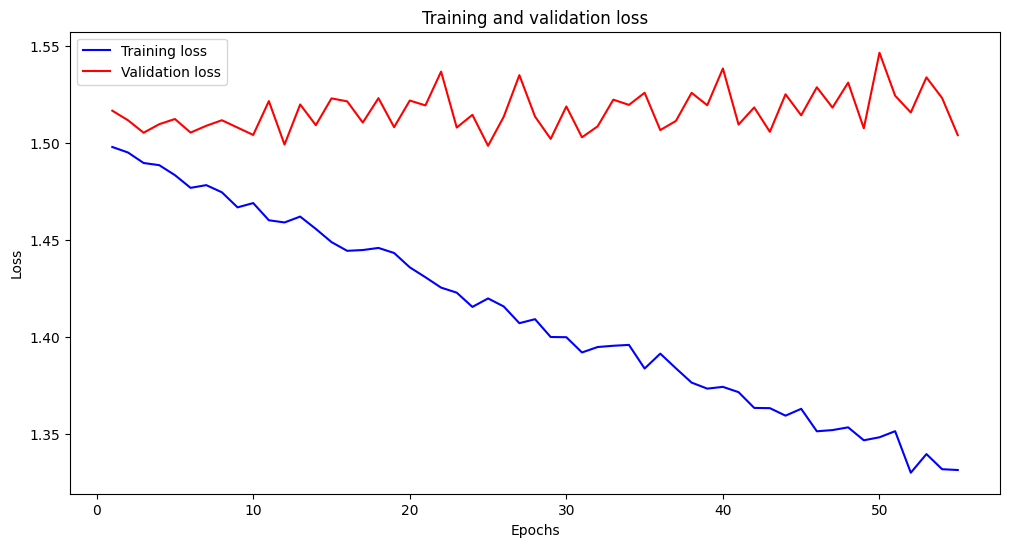

449/449 [==============================] - 11s 24ms/step - loss: 1.3296 - accuracy: 0.5179 - val_loss: 1.5239 - val_accuracy: 0.4400
Epoch 57/200
449/449 [==============================] - 10s 23ms/step - loss: 1.3231 - accuracy: 0.5212 - val_loss: 1.5224 - val_accuracy: 0.4377
Epoch 58/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3277 - accuracy: 0.5188 - val_loss: 1.5267 - val_accuracy: 0.4397
Epoch 59/200
449/449 [==============================] - 10s 23ms/step - loss: 1.3179 - accuracy: 0.5264 - val_loss: 1.5379 - val_accuracy: 0.4224
Epoch 60/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3183 - accuracy: 0.5236 - val_loss: 1.5229 - val_accuracy: 0.4308
Epoch 61/200
447/449 [============================>.] - ETA: 0s - loss: 1.3172 - accuracy: 0.5236

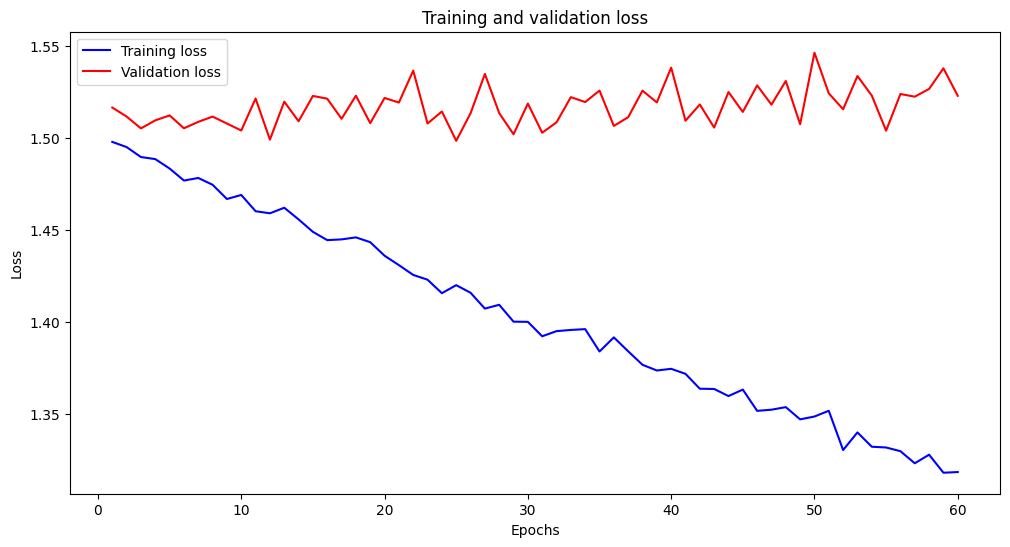

449/449 [==============================] - 11s 24ms/step - loss: 1.3172 - accuracy: 0.5234 - val_loss: 1.5303 - val_accuracy: 0.4352
Epoch 62/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3136 - accuracy: 0.5256 - val_loss: 1.5285 - val_accuracy: 0.4291
Epoch 63/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3119 - accuracy: 0.5256 - val_loss: 1.5305 - val_accuracy: 0.4310
Epoch 64/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3081 - accuracy: 0.5237 - val_loss: 1.5321 - val_accuracy: 0.4333
Epoch 65/200
449/449 [==============================] - 10s 22ms/step - loss: 1.3085 - accuracy: 0.5293 - val_loss: 1.5207 - val_accuracy: 0.4391
Epoch 66/200
449/449 [==============================] - ETA: 0s - loss: 1.2997 - accuracy: 0.5311

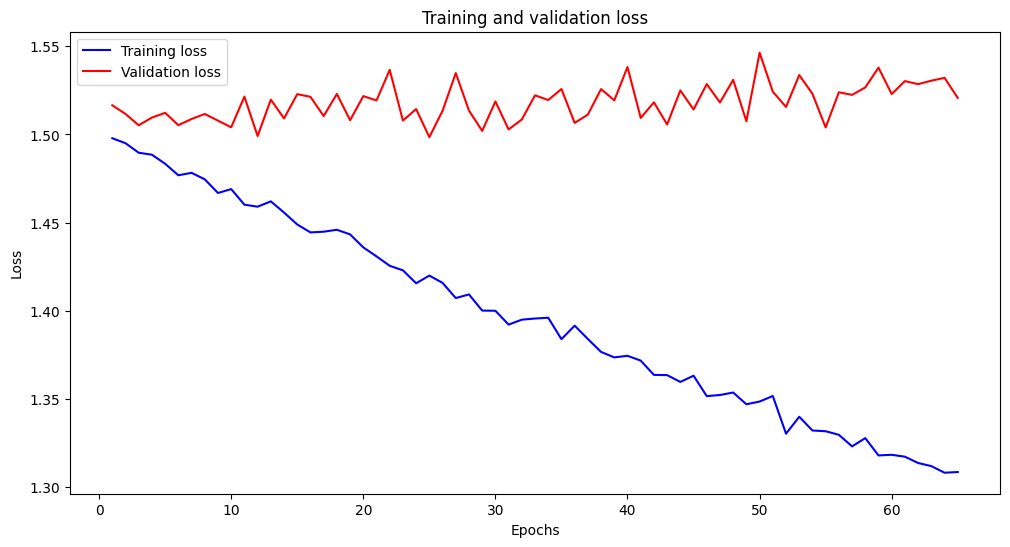

449/449 [==============================] - 11s 24ms/step - loss: 1.2997 - accuracy: 0.5311 - val_loss: 1.5227 - val_accuracy: 0.4447
Epoch 67/200
449/449 [==============================] - 10s 21ms/step - loss: 1.2966 - accuracy: 0.5332 - val_loss: 1.5435 - val_accuracy: 0.4433
Epoch 68/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2969 - accuracy: 0.5314 - val_loss: 1.5263 - val_accuracy: 0.4391
Epoch 69/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2943 - accuracy: 0.5375 - val_loss: 1.5280 - val_accuracy: 0.4386
Epoch 70/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2919 - accuracy: 0.5351 - val_loss: 1.5324 - val_accuracy: 0.4416
Epoch 71/200
448/449 [============================>.] - ETA: 0s - loss: 1.2937 - accuracy: 0.5358

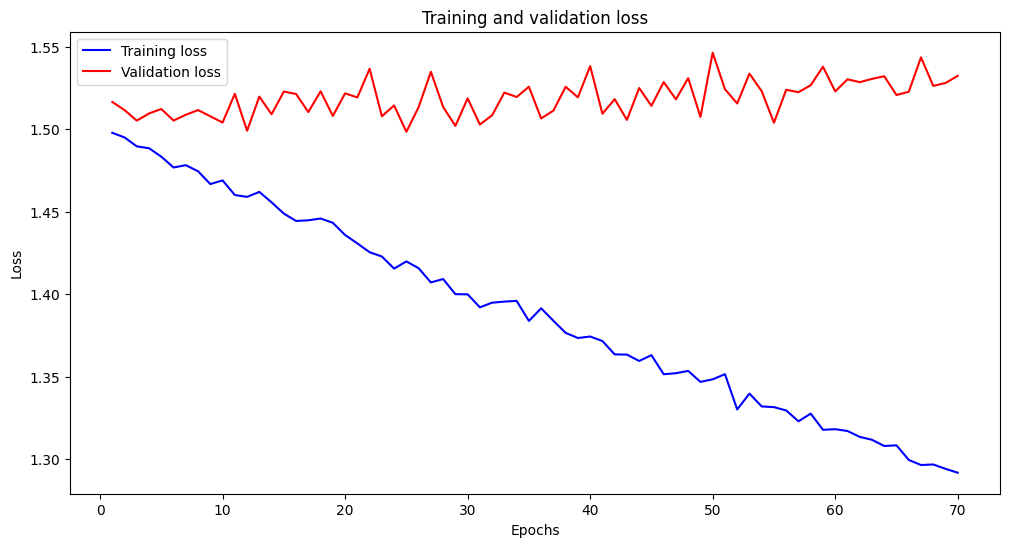

449/449 [==============================] - 10s 23ms/step - loss: 1.2938 - accuracy: 0.5357 - val_loss: 1.5230 - val_accuracy: 0.4366
Epoch 72/200
449/449 [==============================] - 10s 23ms/step - loss: 1.2865 - accuracy: 0.5370 - val_loss: 1.5300 - val_accuracy: 0.4433
Epoch 73/200
449/449 [==============================] - 10s 23ms/step - loss: 1.2879 - accuracy: 0.5368 - val_loss: 1.5418 - val_accuracy: 0.4335
Epoch 74/200
449/449 [==============================] - 10s 23ms/step - loss: 1.2813 - accuracy: 0.5402 - val_loss: 1.5256 - val_accuracy: 0.4374
Epoch 75/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2790 - accuracy: 0.5390 - val_loss: 1.5396 - val_accuracy: 0.4372
Epoch 76/200
449/449 [==============================] - ETA: 0s - loss: 1.2813 - accuracy: 0.5409

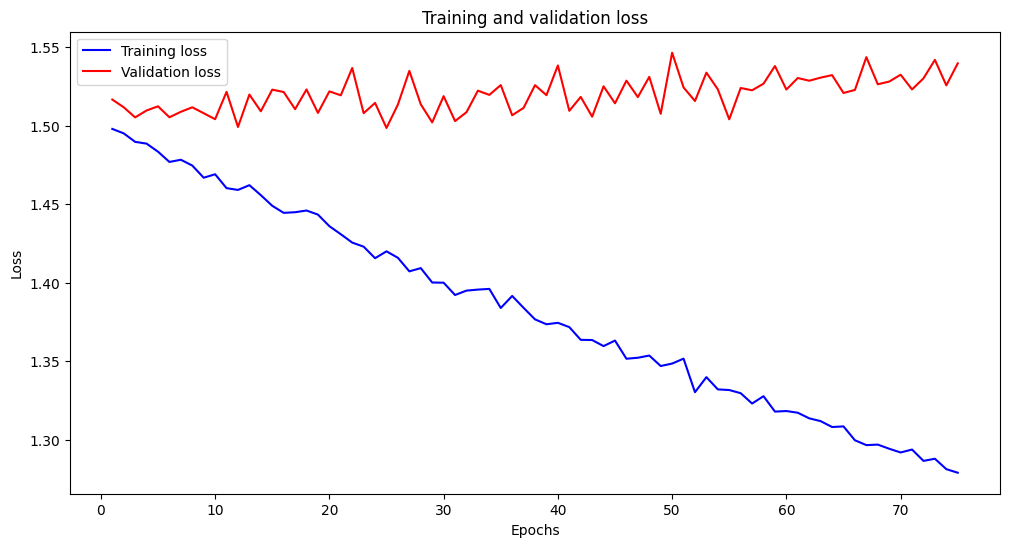

449/449 [==============================] - 11s 24ms/step - loss: 1.2813 - accuracy: 0.5409 - val_loss: 1.5203 - val_accuracy: 0.4430
Epoch 77/200
449/449 [==============================] - 10s 23ms/step - loss: 1.2737 - accuracy: 0.5422 - val_loss: 1.5367 - val_accuracy: 0.4380
Epoch 78/200
449/449 [==============================] - 10s 23ms/step - loss: 1.2618 - accuracy: 0.5467 - val_loss: 1.5536 - val_accuracy: 0.4361
Epoch 79/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2707 - accuracy: 0.5405 - val_loss: 1.5390 - val_accuracy: 0.4439
Epoch 80/200
449/449 [==============================] - 10s 23ms/step - loss: 1.2678 - accuracy: 0.5438 - val_loss: 1.5324 - val_accuracy: 0.4366
Epoch 81/200
448/449 [============================>.] - ETA: 0s - loss: 1.2689 - accuracy: 0.5449

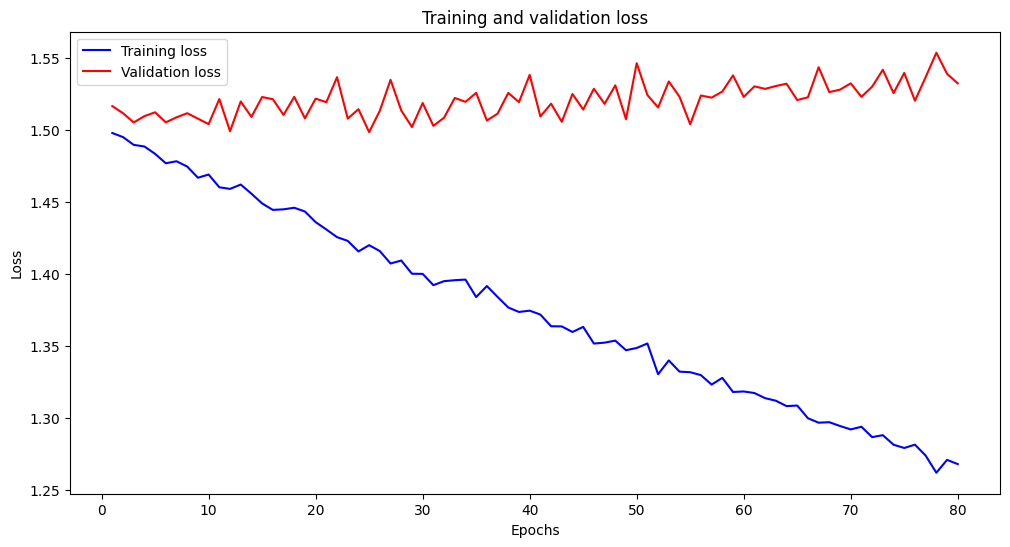

449/449 [==============================] - 11s 24ms/step - loss: 1.2690 - accuracy: 0.5449 - val_loss: 1.5437 - val_accuracy: 0.4344
Epoch 82/200
449/449 [==============================] - 10s 23ms/step - loss: 1.2731 - accuracy: 0.5447 - val_loss: 1.5528 - val_accuracy: 0.4355
Epoch 83/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2595 - accuracy: 0.5457 - val_loss: 1.5380 - val_accuracy: 0.4430
Epoch 84/200
449/449 [==============================] - 10s 23ms/step - loss: 1.2566 - accuracy: 0.5516 - val_loss: 1.5557 - val_accuracy: 0.4372
Epoch 85/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2613 - accuracy: 0.5482 - val_loss: 1.5545 - val_accuracy: 0.4427
Epoch 86/200
448/449 [============================>.] - ETA: 0s - loss: 1.2618 - accuracy: 0.5475

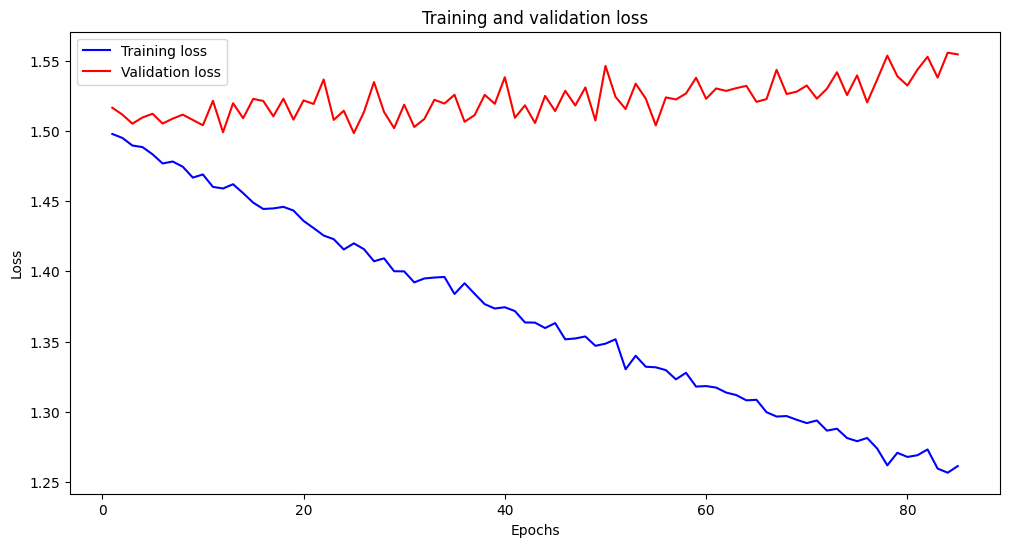

449/449 [==============================] - 11s 24ms/step - loss: 1.2614 - accuracy: 0.5477 - val_loss: 1.5487 - val_accuracy: 0.4358
Epoch 87/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2496 - accuracy: 0.5539 - val_loss: 1.5502 - val_accuracy: 0.4377
Epoch 88/200
449/449 [==============================] - 10s 23ms/step - loss: 1.2542 - accuracy: 0.5563 - val_loss: 1.5564 - val_accuracy: 0.4391
Epoch 89/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2537 - accuracy: 0.5512 - val_loss: 1.5276 - val_accuracy: 0.4388
Epoch 90/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2454 - accuracy: 0.5567 - val_loss: 1.5413 - val_accuracy: 0.4397
Epoch 91/200
448/449 [============================>.] - ETA: 0s - loss: 1.2394 - accuracy: 0.5563

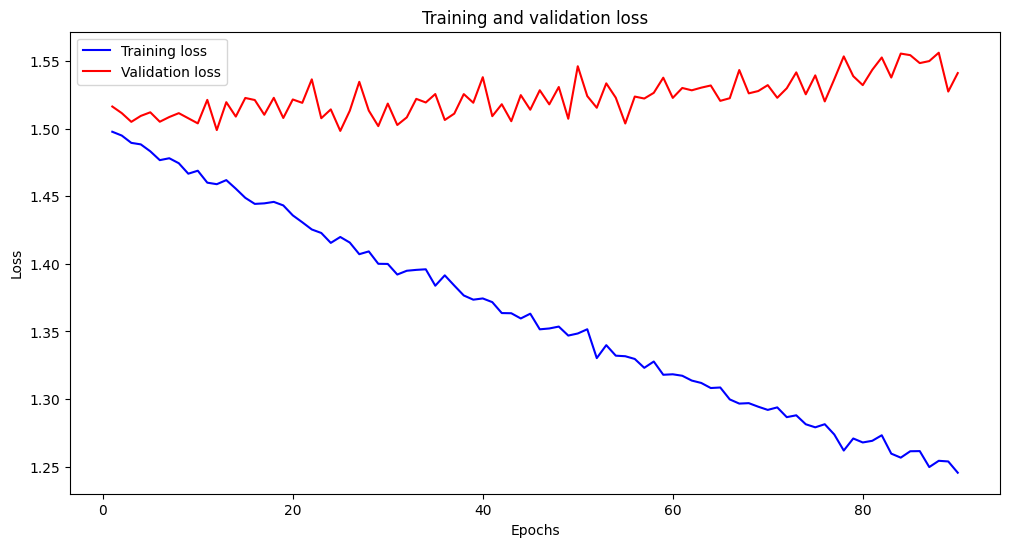

449/449 [==============================] - 12s 26ms/step - loss: 1.2393 - accuracy: 0.5563 - val_loss: 1.5434 - val_accuracy: 0.4361
Epoch 92/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2474 - accuracy: 0.5562 - val_loss: 1.5714 - val_accuracy: 0.4450
Epoch 93/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2371 - accuracy: 0.5601 - val_loss: 1.5366 - val_accuracy: 0.4483
Epoch 94/200
449/449 [==============================] - 10s 23ms/step - loss: 1.2378 - accuracy: 0.5597 - val_loss: 1.5552 - val_accuracy: 0.4330
Epoch 95/200
449/449 [==============================] - 10s 23ms/step - loss: 1.2380 - accuracy: 0.5627 - val_loss: 1.5564 - val_accuracy: 0.4447
Epoch 96/200
449/449 [==============================] - ETA: 0s - loss: 1.2320 - accuracy: 0.5619

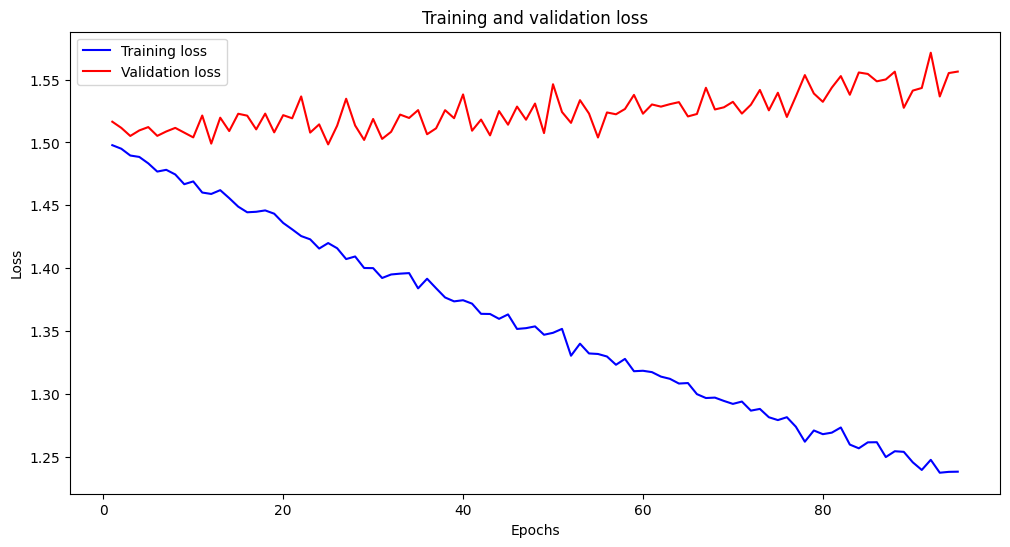

449/449 [==============================] - 11s 24ms/step - loss: 1.2320 - accuracy: 0.5619 - val_loss: 1.5373 - val_accuracy: 0.4436
Epoch 97/200
449/449 [==============================] - 10s 23ms/step - loss: 1.2268 - accuracy: 0.5645 - val_loss: 1.5579 - val_accuracy: 0.4411
Epoch 98/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2281 - accuracy: 0.5675 - val_loss: 1.5529 - val_accuracy: 0.4400
Epoch 99/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2262 - accuracy: 0.5629 - val_loss: 1.5576 - val_accuracy: 0.4397
Epoch 100/200
449/449 [==============================] - 10s 22ms/step - loss: 1.2350 - accuracy: 0.5572 - val_loss: 1.5661 - val_accuracy: 0.4341
Epoch 101/200
449/449 [==============================] - ETA: 0s - loss: 1.2357 - accuracy: 0.5595

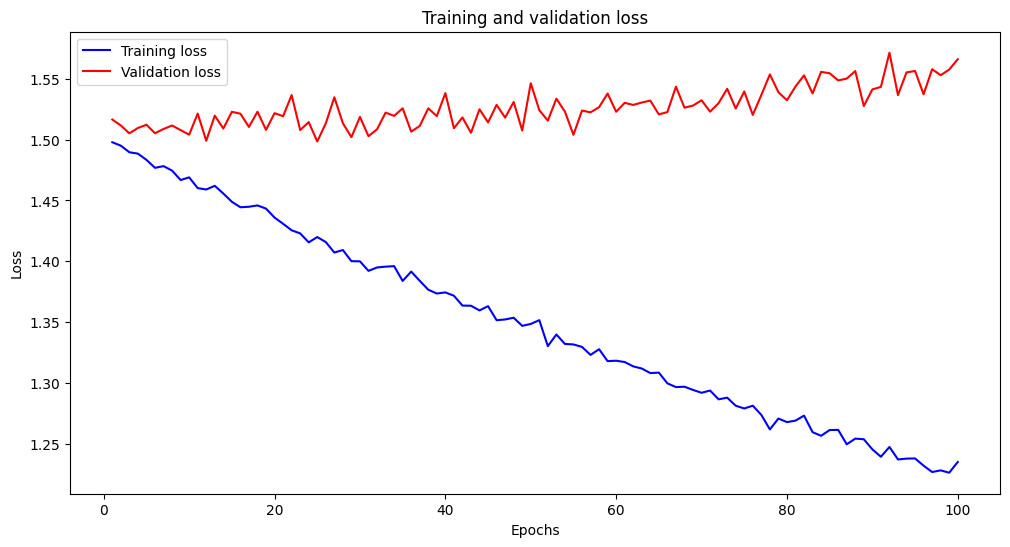

449/449 [==============================] - 11s 23ms/step - loss: 1.2357 - accuracy: 0.5595 - val_loss: 1.5598 - val_accuracy: 0.4285
Epoch 102/200
449/449 [==============================] - 10s 21ms/step - loss: 1.2271 - accuracy: 0.5638 - val_loss: 1.5460 - val_accuracy: 0.4380
Epoch 103/200
449/449 [==============================] - 10s 21ms/step - loss: 1.2143 - accuracy: 0.5686 - val_loss: 1.5639 - val_accuracy: 0.4430
Epoch 104/200
449/449 [==============================] - 10s 21ms/step - loss: 1.2132 - accuracy: 0.5715 - val_loss: 1.5709 - val_accuracy: 0.4433
Epoch 105/200
449/449 [==============================] - 10s 21ms/step - loss: 1.2120 - accuracy: 0.5723 - val_loss: 1.5711 - val_accuracy: 0.4341
Epoch 106/200
448/449 [============================>.] - ETA: 0s - loss: 1.2177 - accuracy: 0.5685

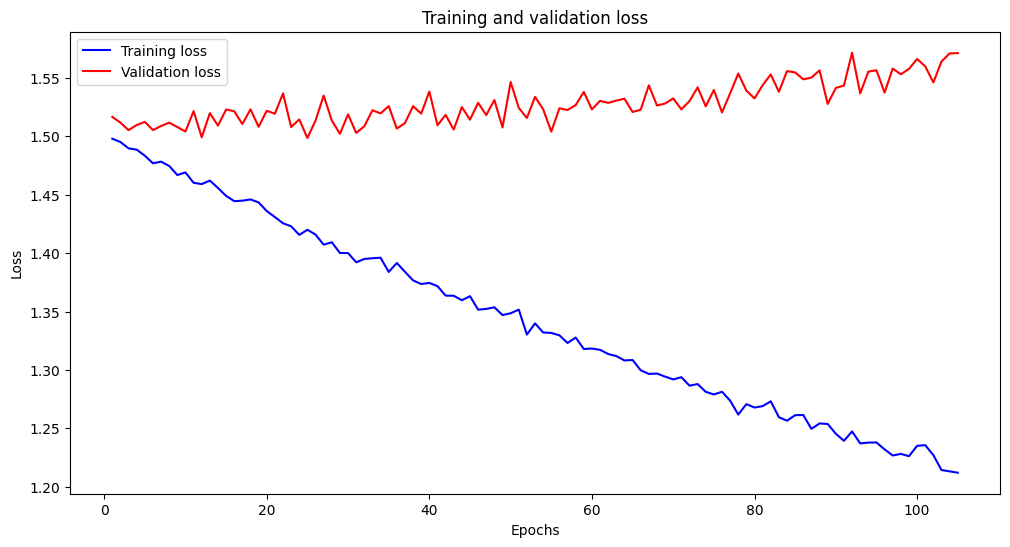

449/449 [==============================] - 10s 23ms/step - loss: 1.2175 - accuracy: 0.5685 - val_loss: 1.5603 - val_accuracy: 0.4369
Epoch 107/200
449/449 [==============================] - 10s 21ms/step - loss: 1.2195 - accuracy: 0.5675 - val_loss: 1.5601 - val_accuracy: 0.4422
Epoch 108/200
449/449 [==============================] - 10s 21ms/step - loss: 1.2104 - accuracy: 0.5741 - val_loss: 1.5372 - val_accuracy: 0.4433
Epoch 109/200
449/449 [==============================] - 10s 21ms/step - loss: 1.2108 - accuracy: 0.5693 - val_loss: 1.5597 - val_accuracy: 0.4408
Epoch 110/200
449/449 [==============================] - 10s 21ms/step - loss: 1.2153 - accuracy: 0.5667 - val_loss: 1.5468 - val_accuracy: 0.4425
Epoch 111/200
449/449 [==============================] - ETA: 0s - loss: 1.2032 - accuracy: 0.5750

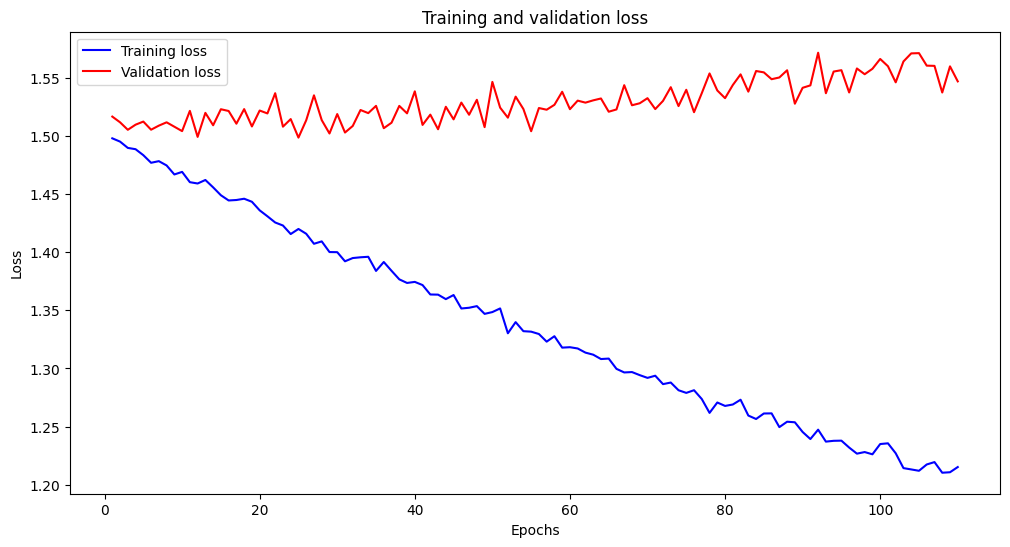

449/449 [==============================] - 10s 23ms/step - loss: 1.2032 - accuracy: 0.5750 - val_loss: 1.5690 - val_accuracy: 0.4394
Epoch 112/200
449/449 [==============================] - 10s 21ms/step - loss: 1.2129 - accuracy: 0.5678 - val_loss: 1.5888 - val_accuracy: 0.4349
Epoch 113/200
449/449 [==============================] - 10s 21ms/step - loss: 1.1971 - accuracy: 0.5784 - val_loss: 1.5581 - val_accuracy: 0.4422
Epoch 114/200
449/449 [==============================] - 10s 21ms/step - loss: 1.1895 - accuracy: 0.5784 - val_loss: 1.5884 - val_accuracy: 0.4313
Epoch 115/200
449/449 [==============================] - 10s 21ms/step - loss: 1.1936 - accuracy: 0.5757 - val_loss: 1.5579 - val_accuracy: 0.4480
Epoch 116/200
448/449 [============================>.] - ETA: 0s - loss: 1.1883 - accuracy: 0.5809

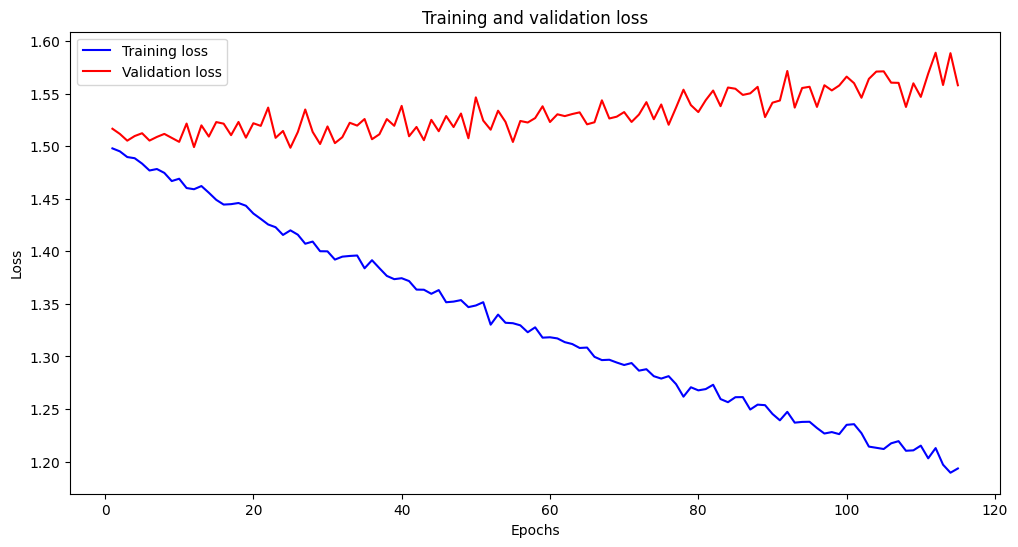

449/449 [==============================] - 10s 23ms/step - loss: 1.1886 - accuracy: 0.5809 - val_loss: 1.5480 - val_accuracy: 0.4483
Epoch 117/200
449/449 [==============================] - 10s 21ms/step - loss: 1.1924 - accuracy: 0.5787 - val_loss: 1.5575 - val_accuracy: 0.4469
Epoch 118/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1904 - accuracy: 0.5819 - val_loss: 1.5791 - val_accuracy: 0.4416
Epoch 119/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1932 - accuracy: 0.5782 - val_loss: 1.5770 - val_accuracy: 0.4352
Epoch 120/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1845 - accuracy: 0.5822 - val_loss: 1.5711 - val_accuracy: 0.4397
Epoch 121/200
448/449 [============================>.] - ETA: 0s - loss: 1.1886 - accuracy: 0.5805

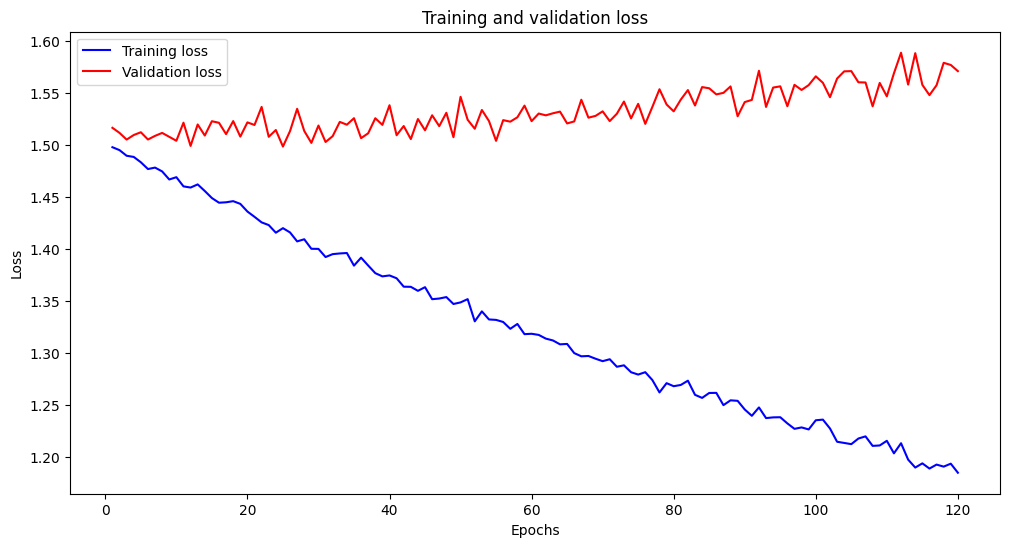

449/449 [==============================] - 11s 24ms/step - loss: 1.1887 - accuracy: 0.5805 - val_loss: 1.5706 - val_accuracy: 0.4397
Epoch 122/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1835 - accuracy: 0.5820 - val_loss: 1.5736 - val_accuracy: 0.4363
Epoch 123/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1878 - accuracy: 0.5836 - val_loss: 1.5552 - val_accuracy: 0.4363
Epoch 124/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1800 - accuracy: 0.5861 - val_loss: 1.5875 - val_accuracy: 0.4358
Epoch 125/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1797 - accuracy: 0.5820 - val_loss: 1.5869 - val_accuracy: 0.4405
Epoch 126/200
447/449 [============================>.] - ETA: 0s - loss: 1.1815 - accuracy: 0.5851

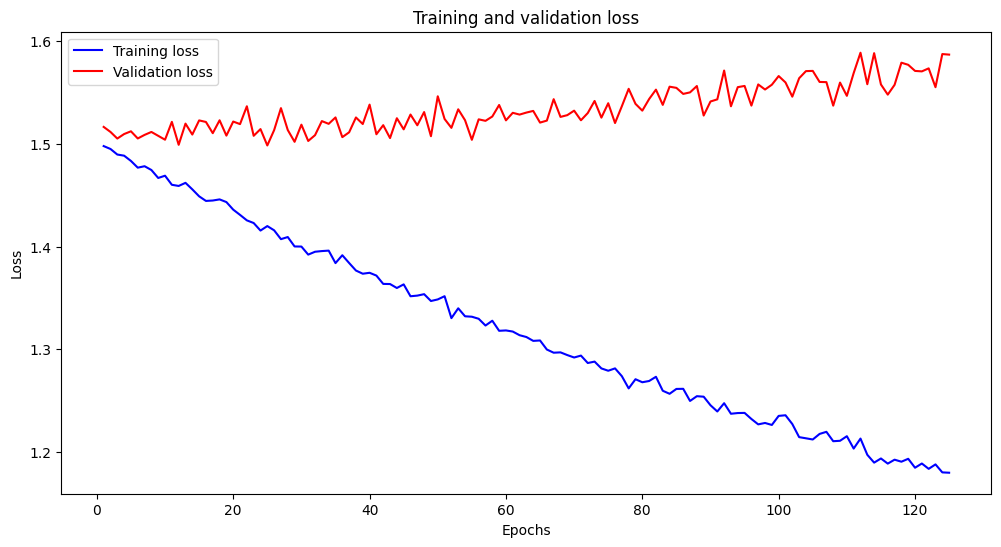

449/449 [==============================] - 11s 23ms/step - loss: 1.1819 - accuracy: 0.5849 - val_loss: 1.5809 - val_accuracy: 0.4422
Epoch 127/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1830 - accuracy: 0.5869 - val_loss: 1.5906 - val_accuracy: 0.4347
Epoch 128/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1682 - accuracy: 0.5909 - val_loss: 1.5980 - val_accuracy: 0.4361
Epoch 129/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1793 - accuracy: 0.5867 - val_loss: 1.5839 - val_accuracy: 0.4352
Epoch 130/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1685 - accuracy: 0.5899 - val_loss: 1.5862 - val_accuracy: 0.4347
Epoch 131/200
448/449 [============================>.] - ETA: 0s - loss: 1.1736 - accuracy: 0.5846

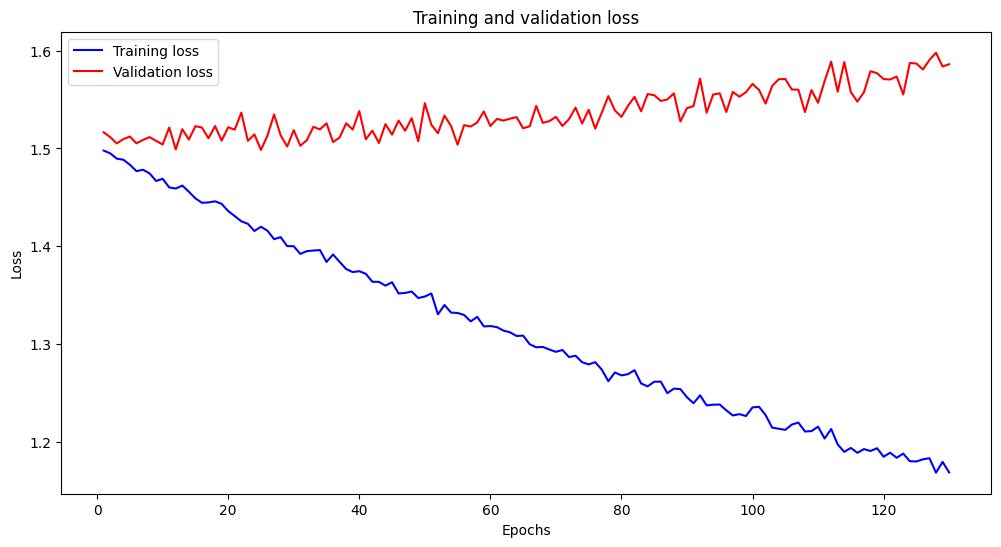

449/449 [==============================] - 10s 23ms/step - loss: 1.1735 - accuracy: 0.5846 - val_loss: 1.5946 - val_accuracy: 0.4369
Epoch 132/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1789 - accuracy: 0.5848 - val_loss: 1.5665 - val_accuracy: 0.4422
Epoch 133/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1744 - accuracy: 0.5864 - val_loss: 1.5597 - val_accuracy: 0.4489
Epoch 134/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1621 - accuracy: 0.5905 - val_loss: 1.5777 - val_accuracy: 0.4478
Epoch 135/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1630 - accuracy: 0.5933 - val_loss: 1.5530 - val_accuracy: 0.4480
Epoch 136/200
448/449 [============================>.] - ETA: 0s - loss: 1.1685 - accuracy: 0.5877

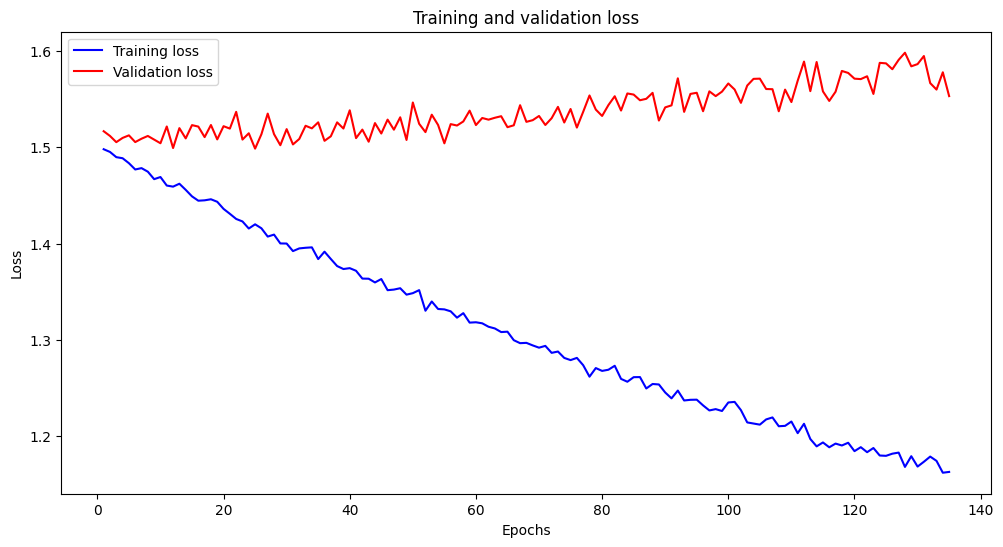

449/449 [==============================] - 11s 24ms/step - loss: 1.1685 - accuracy: 0.5877 - val_loss: 1.5642 - val_accuracy: 0.4486
Epoch 137/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1675 - accuracy: 0.5884 - val_loss: 1.5705 - val_accuracy: 0.4419
Epoch 138/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1592 - accuracy: 0.5933 - val_loss: 1.5890 - val_accuracy: 0.4380
Epoch 139/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1529 - accuracy: 0.5947 - val_loss: 1.5733 - val_accuracy: 0.4439
Epoch 140/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1551 - accuracy: 0.5933 - val_loss: 1.5901 - val_accuracy: 0.4319
Epoch 141/200
448/449 [============================>.] - ETA: 0s - loss: 1.1526 - accuracy: 0.5925

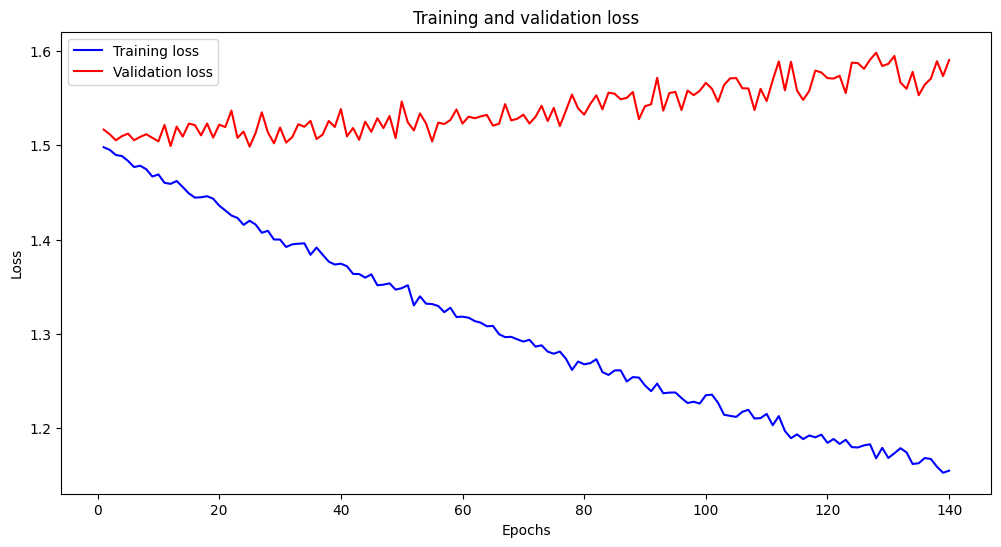

449/449 [==============================] - 10s 23ms/step - loss: 1.1527 - accuracy: 0.5924 - val_loss: 1.5815 - val_accuracy: 0.4522
Epoch 142/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1472 - accuracy: 0.5933 - val_loss: 1.5852 - val_accuracy: 0.4333
Epoch 143/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1506 - accuracy: 0.5935 - val_loss: 1.5902 - val_accuracy: 0.4386
Epoch 144/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1593 - accuracy: 0.5933 - val_loss: 1.5827 - val_accuracy: 0.4366
Epoch 145/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1489 - accuracy: 0.6008 - val_loss: 1.5845 - val_accuracy: 0.4408
Epoch 146/200
448/449 [============================>.] - ETA: 0s - loss: 1.1476 - accuracy: 0.5991

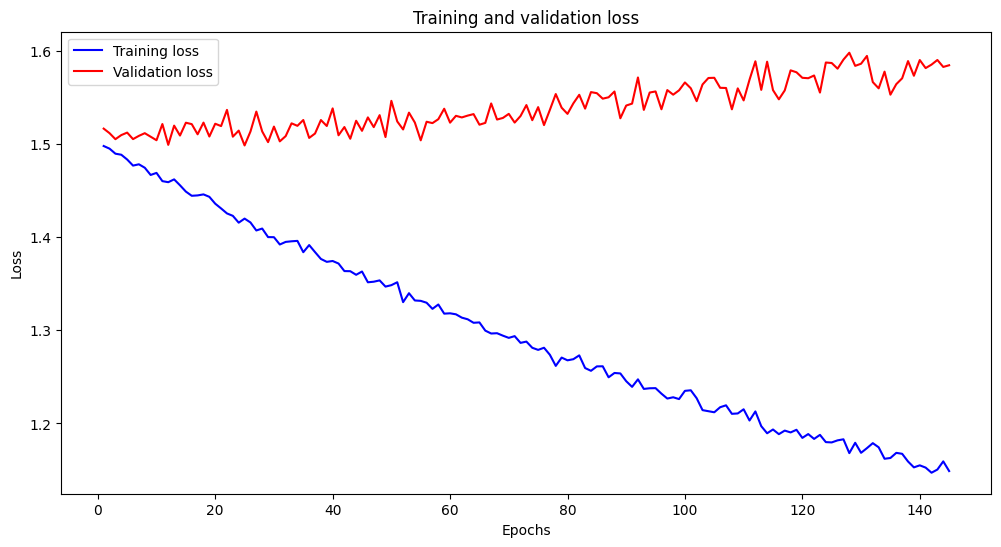

449/449 [==============================] - 11s 24ms/step - loss: 1.1478 - accuracy: 0.5989 - val_loss: 1.6000 - val_accuracy: 0.4352
Epoch 147/200
449/449 [==============================] - 11s 24ms/step - loss: 1.1506 - accuracy: 0.5983 - val_loss: 1.5749 - val_accuracy: 0.4416
Epoch 148/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1511 - accuracy: 0.5989 - val_loss: 1.5823 - val_accuracy: 0.4444
Epoch 149/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1395 - accuracy: 0.6043 - val_loss: 1.5751 - val_accuracy: 0.4478
Epoch 150/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1404 - accuracy: 0.6023 - val_loss: 1.5914 - val_accuracy: 0.4436
Epoch 151/200
448/449 [============================>.] - ETA: 0s - loss: 1.1533 - accuracy: 0.5943

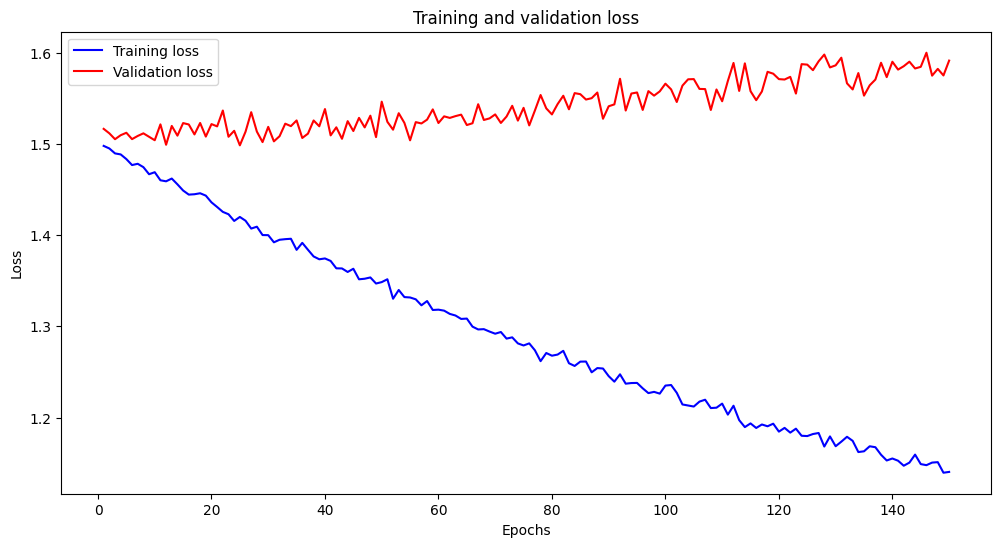

449/449 [==============================] - 11s 24ms/step - loss: 1.1535 - accuracy: 0.5942 - val_loss: 1.5687 - val_accuracy: 0.4447
Epoch 152/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1394 - accuracy: 0.6017 - val_loss: 1.5985 - val_accuracy: 0.4369
Epoch 153/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1357 - accuracy: 0.6026 - val_loss: 1.5983 - val_accuracy: 0.4402
Epoch 154/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1412 - accuracy: 0.5999 - val_loss: 1.5823 - val_accuracy: 0.4383
Epoch 155/200
449/449 [==============================] - 11s 24ms/step - loss: 1.1287 - accuracy: 0.6064 - val_loss: 1.6067 - val_accuracy: 0.4391
Epoch 156/200
449/449 [==============================] - ETA: 0s - loss: 1.1357 - accuracy: 0.6064

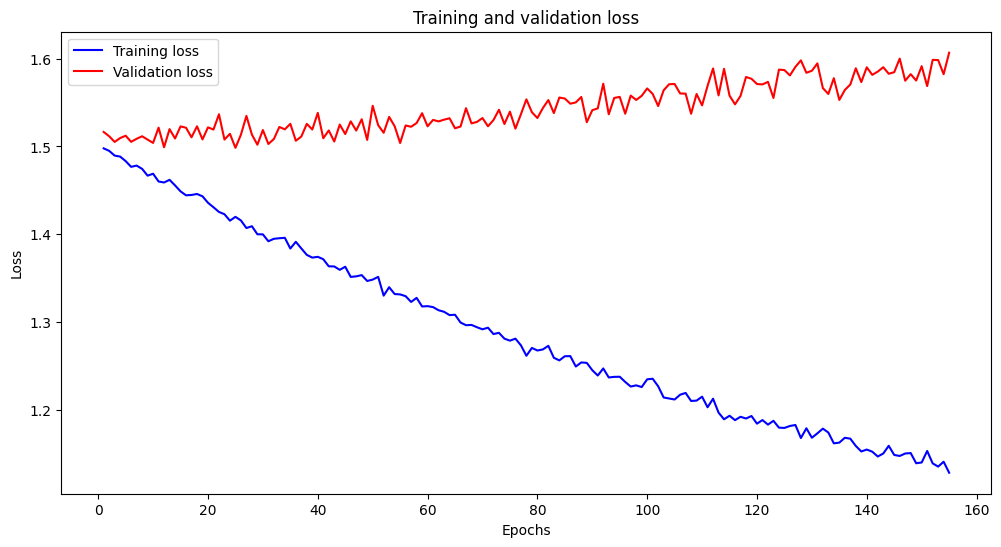

449/449 [==============================] - 11s 24ms/step - loss: 1.1357 - accuracy: 0.6064 - val_loss: 1.5937 - val_accuracy: 0.4397
Epoch 157/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1318 - accuracy: 0.6062 - val_loss: 1.5740 - val_accuracy: 0.4466
Epoch 158/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1284 - accuracy: 0.6042 - val_loss: 1.5952 - val_accuracy: 0.4397
Epoch 159/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1334 - accuracy: 0.6038 - val_loss: 1.5987 - val_accuracy: 0.4413
Epoch 160/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1214 - accuracy: 0.6124 - val_loss: 1.6009 - val_accuracy: 0.4547
Epoch 161/200
448/449 [============================>.] - ETA: 0s - loss: 1.1291 - accuracy: 0.6080

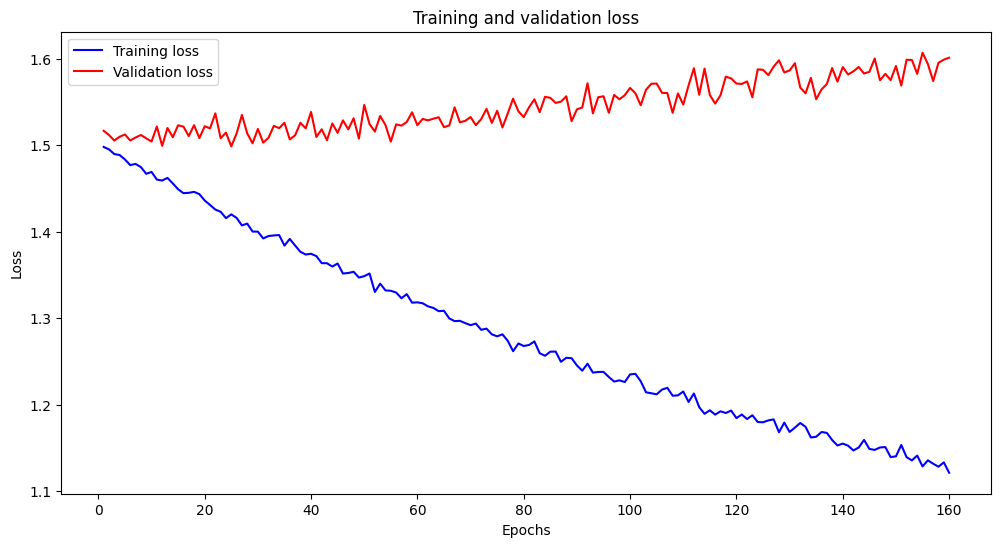

449/449 [==============================] - 11s 23ms/step - loss: 1.1291 - accuracy: 0.6080 - val_loss: 1.6089 - val_accuracy: 0.4469
Epoch 162/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1290 - accuracy: 0.6062 - val_loss: 1.5792 - val_accuracy: 0.4494
Epoch 163/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1328 - accuracy: 0.6032 - val_loss: 1.6051 - val_accuracy: 0.4377
Epoch 164/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1314 - accuracy: 0.6061 - val_loss: 1.5944 - val_accuracy: 0.4430
Epoch 165/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1231 - accuracy: 0.6111 - val_loss: 1.5872 - val_accuracy: 0.4466
Epoch 166/200
449/449 [==============================] - ETA: 0s - loss: 1.1239 - accuracy: 0.6085

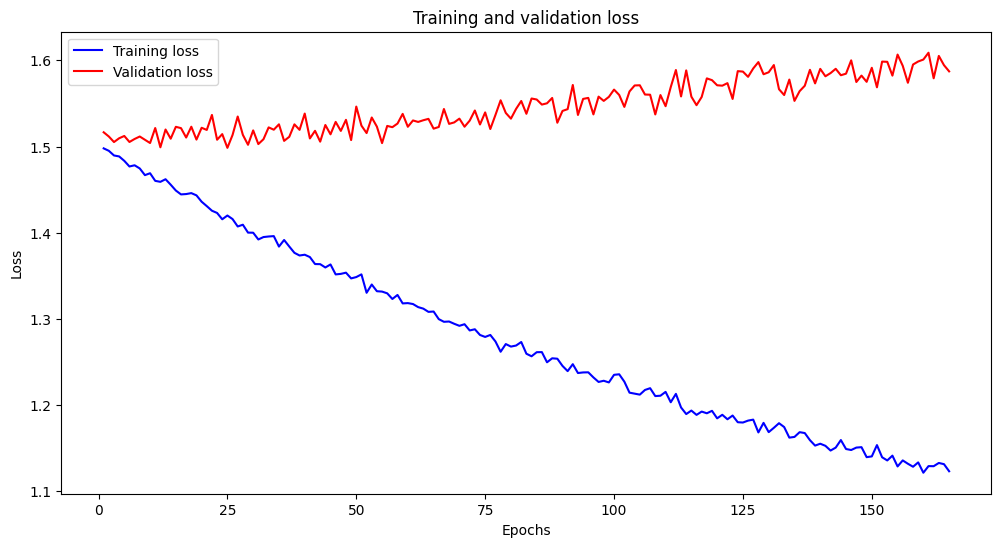

449/449 [==============================] - 11s 24ms/step - loss: 1.1239 - accuracy: 0.6085 - val_loss: 1.5898 - val_accuracy: 0.4450
Epoch 167/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1241 - accuracy: 0.6086 - val_loss: 1.6015 - val_accuracy: 0.4441
Epoch 168/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1208 - accuracy: 0.6104 - val_loss: 1.5896 - val_accuracy: 0.4447
Epoch 169/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1253 - accuracy: 0.6074 - val_loss: 1.6174 - val_accuracy: 0.4319
Epoch 170/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1160 - accuracy: 0.6120 - val_loss: 1.5889 - val_accuracy: 0.4531
Epoch 171/200
447/449 [============================>.] - ETA: 0s - loss: 1.1212 - accuracy: 0.6115

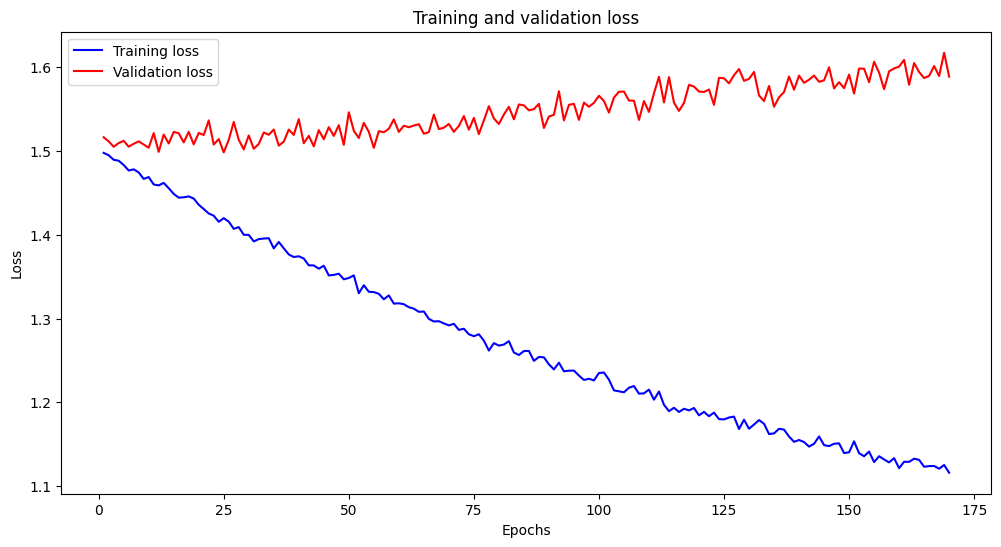

449/449 [==============================] - 11s 24ms/step - loss: 1.1214 - accuracy: 0.6115 - val_loss: 1.6095 - val_accuracy: 0.4430
Epoch 172/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1116 - accuracy: 0.6153 - val_loss: 1.6018 - val_accuracy: 0.4397
Epoch 173/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1241 - accuracy: 0.6092 - val_loss: 1.6169 - val_accuracy: 0.4358
Epoch 174/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1117 - accuracy: 0.6142 - val_loss: 1.5887 - val_accuracy: 0.4369
Epoch 175/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1139 - accuracy: 0.6145 - val_loss: 1.6071 - val_accuracy: 0.4405
Epoch 176/200
448/449 [============================>.] - ETA: 0s - loss: 1.1217 - accuracy: 0.6119

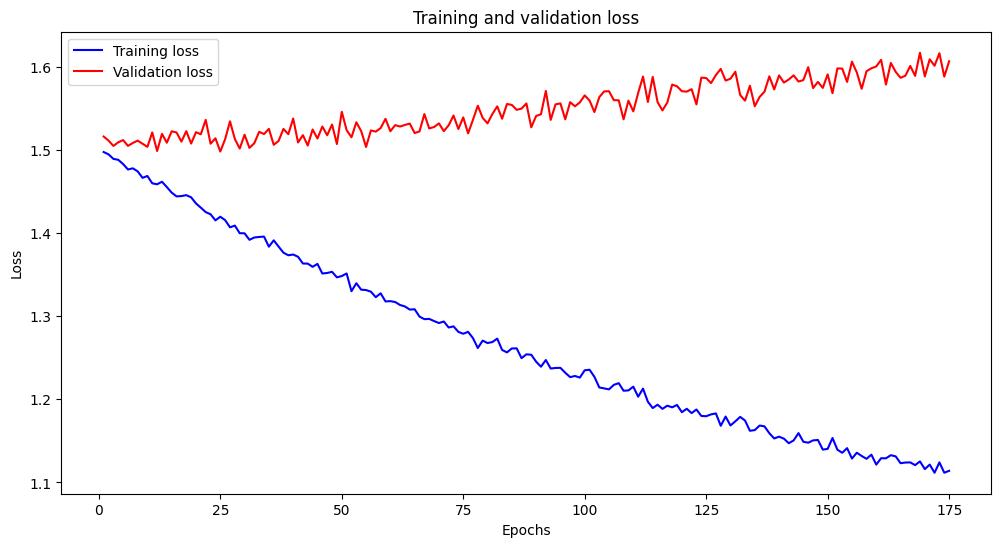

449/449 [==============================] - 11s 25ms/step - loss: 1.1216 - accuracy: 0.6120 - val_loss: 1.5929 - val_accuracy: 0.4466
Epoch 177/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1148 - accuracy: 0.6115 - val_loss: 1.5830 - val_accuracy: 0.4408
Epoch 178/200
449/449 [==============================] - 10s 22ms/step - loss: 1.0970 - accuracy: 0.6207 - val_loss: 1.6020 - val_accuracy: 0.4533
Epoch 179/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1148 - accuracy: 0.6133 - val_loss: 1.6024 - val_accuracy: 0.4472
Epoch 180/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1108 - accuracy: 0.6137 - val_loss: 1.6031 - val_accuracy: 0.4478
Epoch 181/200
447/449 [============================>.] - ETA: 0s - loss: 1.1006 - accuracy: 0.6192

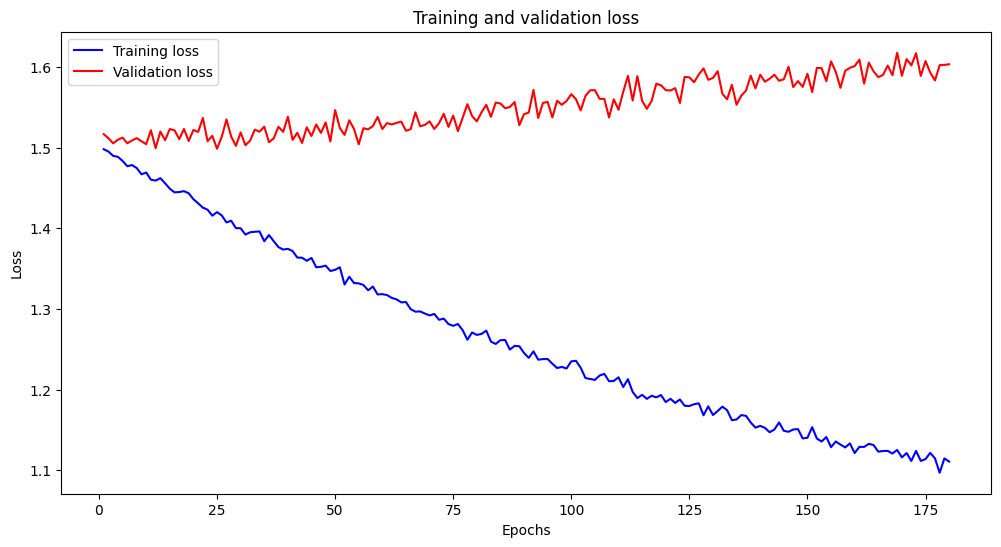

449/449 [==============================] - 10s 23ms/step - loss: 1.1003 - accuracy: 0.6192 - val_loss: 1.6123 - val_accuracy: 0.4405
Epoch 182/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1001 - accuracy: 0.6185 - val_loss: 1.5962 - val_accuracy: 0.4352
Epoch 183/200
449/449 [==============================] - 10s 22ms/step - loss: 1.1045 - accuracy: 0.6159 - val_loss: 1.6010 - val_accuracy: 0.4361
Epoch 184/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1052 - accuracy: 0.6222 - val_loss: 1.6060 - val_accuracy: 0.4394
Epoch 185/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1024 - accuracy: 0.6178 - val_loss: 1.6141 - val_accuracy: 0.4466
Epoch 186/200
447/449 [============================>.] - ETA: 0s - loss: 1.1037 - accuracy: 0.6193

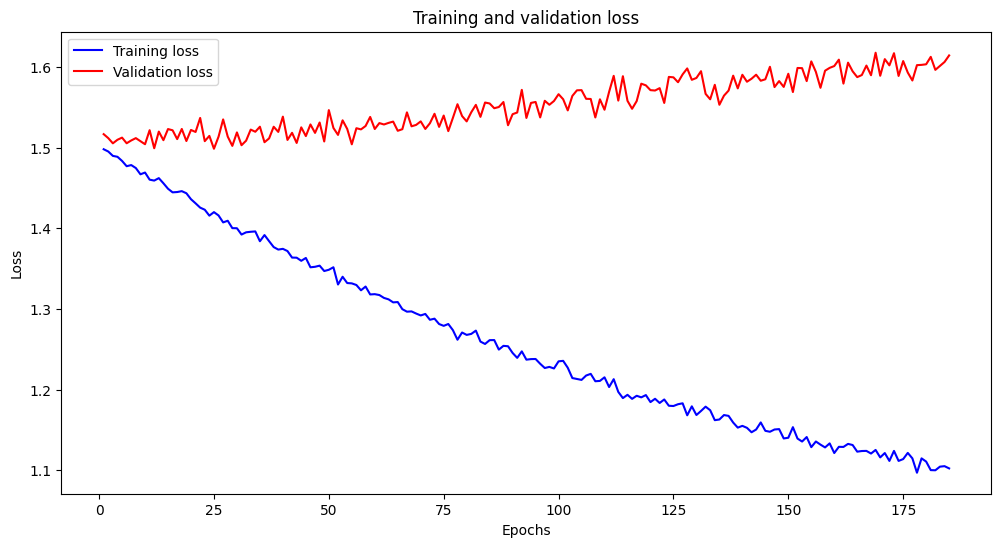

449/449 [==============================] - 11s 25ms/step - loss: 1.1041 - accuracy: 0.6190 - val_loss: 1.6062 - val_accuracy: 0.4461
Epoch 187/200
449/449 [==============================] - 10s 23ms/step - loss: 1.1029 - accuracy: 0.6182 - val_loss: 1.6224 - val_accuracy: 0.4430
Epoch 188/200
449/449 [==============================] - 10s 23ms/step - loss: 1.0990 - accuracy: 0.6195 - val_loss: 1.6113 - val_accuracy: 0.4486
Epoch 189/200
449/449 [==============================] - 10s 23ms/step - loss: 1.0926 - accuracy: 0.6218 - val_loss: 1.6188 - val_accuracy: 0.4478
Epoch 190/200
449/449 [==============================] - 10s 22ms/step - loss: 1.0998 - accuracy: 0.6171 - val_loss: 1.6034 - val_accuracy: 0.4489
Epoch 191/200
447/449 [============================>.] - ETA: 0s - loss: 1.0996 - accuracy: 0.6161

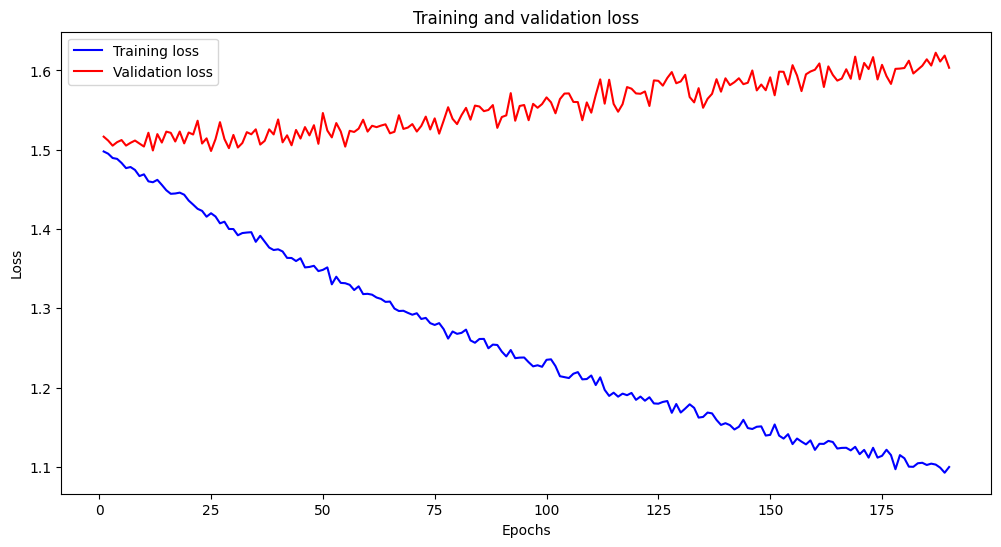

449/449 [==============================] - 11s 24ms/step - loss: 1.0995 - accuracy: 0.6160 - val_loss: 1.6078 - val_accuracy: 0.4517
Epoch 192/200
449/449 [==============================] - 10s 23ms/step - loss: 1.0959 - accuracy: 0.6249 - val_loss: 1.6215 - val_accuracy: 0.4478
Epoch 193/200
449/449 [==============================] - 10s 23ms/step - loss: 1.0930 - accuracy: 0.6231 - val_loss: 1.6200 - val_accuracy: 0.4416
Epoch 194/200
449/449 [==============================] - 10s 22ms/step - loss: 1.0880 - accuracy: 0.6238 - val_loss: 1.6269 - val_accuracy: 0.4436
Epoch 195/200
449/449 [==============================] - 10s 22ms/step - loss: 1.0857 - accuracy: 0.6250 - val_loss: 1.6302 - val_accuracy: 0.4408
Epoch 196/200
449/449 [==============================] - ETA: 0s - loss: 1.0903 - accuracy: 0.6205

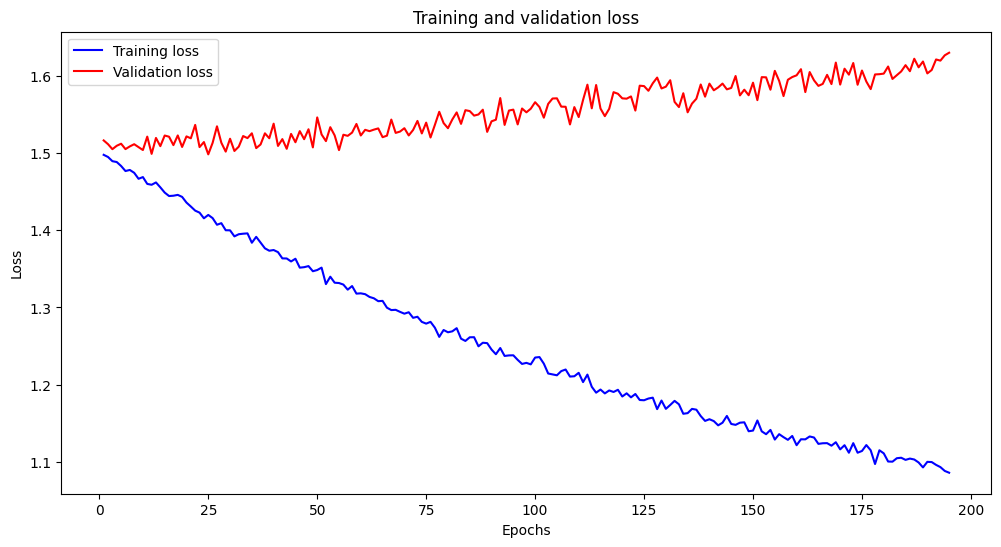

449/449 [==============================] - 11s 24ms/step - loss: 1.0903 - accuracy: 0.6205 - val_loss: 1.6298 - val_accuracy: 0.4397
Epoch 197/200
449/449 [==============================] - 10s 22ms/step - loss: 1.0876 - accuracy: 0.6256 - val_loss: 1.5965 - val_accuracy: 0.4489
Epoch 198/200
449/449 [==============================] - 10s 22ms/step - loss: 1.0889 - accuracy: 0.6242 - val_loss: 1.6256 - val_accuracy: 0.4377
Epoch 199/200
449/449 [==============================] - 10s 23ms/step - loss: 1.0896 - accuracy: 0.6228 - val_loss: 1.6434 - val_accuracy: 0.4380
Epoch 200/200
449/449 [==============================] - 10s 22ms/step - loss: 1.0910 - accuracy: 0.6217 - val_loss: 1.6255 - val_accuracy: 0.4352


In [56]:
#Training the model
history = model.fit(X_train, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, test_y),
          shuffle=True,
          callbacks=[PlotLossesCallback()])

In [57]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


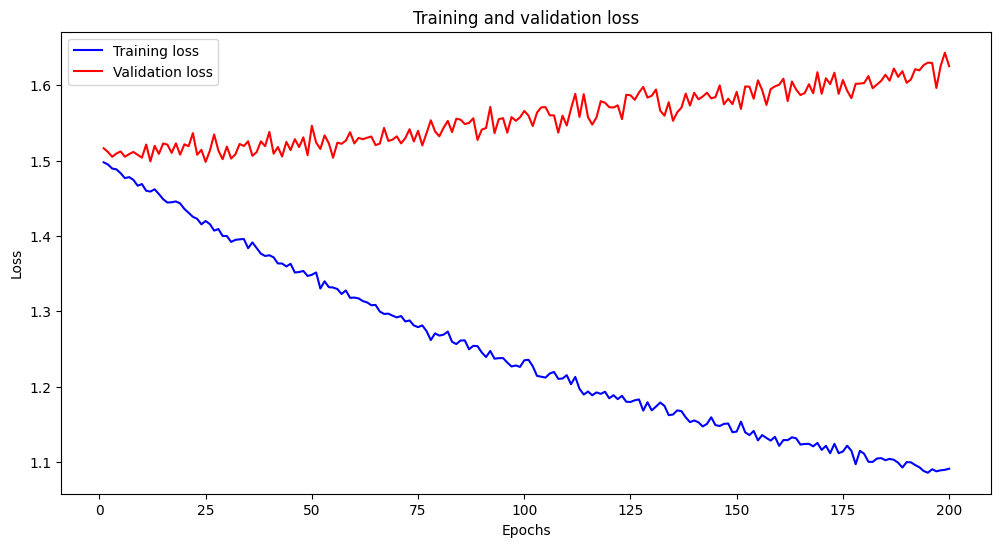

In [58]:
plot_losses(history)

In [88]:
#Saving the  model to  use it later on
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer_200epochs_22-11-2023.h5")

In [81]:
def get_label_from_dataset(data):
    label = []
    for i in data:
        #print(i)
        label.append(np.argmax(i))
    label_array = np.array(label)
    return label_array
        

In [85]:
train_predictions = model.predict(X_train)
train_predictions = get_label_from_dataset(train_predictions)
train_true_labels = get_label_from_dataset(train_y)

898/898 [==============================] - 1s 2ms/step


In [86]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder


# Calculate precision, recall, and F1 score
precision = precision_score(train_true_labels, train_predictions, average='weighted')
recall = recall_score(train_true_labels, train_predictions, average='weighted')
f1 = f1_score(train_true_labels, train_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print detailed classification report
report = classification_report(train_true_labels, train_predictions)
print('Classification Report:\n', report)

Precision: 0.8576
Recall: 0.8526
F1 Score: 0.8525
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      3995
           1       0.89      0.95      0.92       436
           2       0.93      0.75      0.83      4097
           3       0.87      0.92      0.89      7215
           4       0.85      0.81      0.83      4830
           5       0.92      0.89      0.91      3171
           6       0.75      0.88      0.81      4965

    accuracy                           0.85     28709
   macro avg       0.87      0.86      0.86     28709
weighted avg       0.86      0.85      0.85     28709



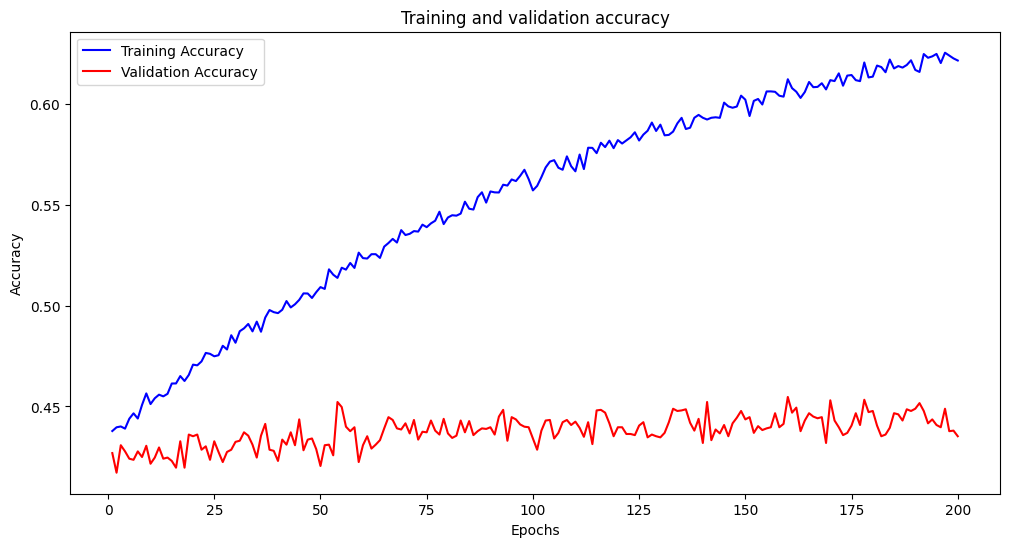

In [87]:
def plot_accuracy(history):
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, 'b-', label='Training Accuracy')  # 'b-' for blue solid line
    plt.plot(epochs, val_loss, 'r-', label='Validation Accuracy')  # 'r-' for red solid line
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_accuracy(history)